In [1]:
# %pip install imblearn

In [2]:
# %pip install tensorflow

In [3]:
# %pip install shap

In [67]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scipy.stats import skew
from scipy.special import boxcox1p
from collections import Counter
import shap  # Ensure SHAP is installed: pip install shap
from lime import lime_tabular

import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv("/Users/sruthynath/Mac Docs/MPSTME/Travel.csv")
data.head()

CustomerID  ProdTaken   Age    TypeofContact  CityTier  DurationOfPitch  \
0      200000          1  41.0     Self Enquiry         3              6.0   
1      200001          0  49.0  Company Invited         1             14.0   
2      200002          1  37.0     Self Enquiry         1              8.0   
3      200003          0  33.0  Company Invited         1              9.0   
4      200004          0   NaN     Self Enquiry         1              8.0   

       Occupation  Gender  NumberOfPersonVisiting  NumberOfFollowups  \
0        Salaried  Female                       3                3.0   
1        Salaried    Male                       3                4.0   
2     Free Lancer    Male                       3                4.0   
3        Salaried  Female                       2                3.0   
4  Small Business    Male                       2                3.0   

  ProductPitched  PreferredPropertyStar MaritalStatus  NumberOfTrips  \
0         Deluxe                    3.0        Single            1.0   
1         Deluxe                    4.0      Divorced            2.0   
2          Basic                    3.0        Single            7.0   
3          Basic                    3.0      Divorced            2.0   
4          Basic                    4.0      Divorced            1.0   

   Passport  PitchSatisfactionScore  OwnCar  NumberOfChildrenVisiting  \
0         1                       2       1                       0.0   
1         0                       3       1                       2.0   
2         1                       3       0                       0.0   
3         1                       5       1                       1.0   
4         0                       5       1                       0.0   

  Designation  MonthlyIncome  
0     Manager        20993.0  
1     Manager        20130.0  
2   Executive        17090.0  
3   Executive        17909.0  
4   Executive        18468.0

Feature	Description

CustomerID - Unique identifier for each customer.

ProdTaken - Binary target variable: whether the product was taken (1) or not (0).

Age -	Age of the customer.

TypeofContact -	How the customer was contacted (e.g., Self Enquiry, Company Invited).

CityTier - Tier of the city where the customer resides.

DurationOfPitch	- Duration of the product pitch in minutes.

Occupation -	Occupation of the customer (Salaried, Free Lancer, etc.).

Gender -	Gender of the customer.

NumberOfPersonVisiting -	Number of people visiting with the customer.

NumberOfFollowups -	Number of follow-up interactions after the pitch.

ProductPitched -	Type of product pitched (Deluxe, Basic, etc.).

PreferredPropertyStar -	Customer's preferred star rating for the property (e.g., 3-star, 4-star).

MaritalStatus -	Marital status (Single, Divorced, etc.).

NumberOfTrips -	Number of trips planned by the customer.

Passport -	Binary: whether the customer has a passport (1) or not (0).

PitchSatisfactionScore -	Score indicating customer satisfaction with the pitch.

OwnCar -	Binary: whether the customer owns a car (1) or not (0).

NumberOfChildrenVisiting -	Number of children visiting with the customer.

Designation	- Customer's designation (Manager, Executive, etc.).

MonthlyIncome -	Monthly income of the customer.

In [6]:
print(data.shape)

(4888, 20)


There are 4888 rows and 20 columns

In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4888 non-null   int64  
 1   ProdTaken                 4888 non-null   int64  
 2   Age                       4662 non-null   float64
 3   TypeofContact             4863 non-null   object 
 4   CityTier                  4888 non-null   int64  
 5   DurationOfPitch           4637 non-null   float64
 6   Occupation                4888 non-null   object 
 7   Gender                    4888 non-null   object 
 8   NumberOfPersonVisiting    4888 non-null   int64  
 9   NumberOfFollowups         4843 non-null   float64
 10  ProductPitched            4888 non-null   object 
 11  PreferredPropertyStar     4862 non-null   float64
 12  MaritalStatus             4888 non-null   object 
 13  NumberOfTrips             4748 non-null   float64
 14  Passport

Out of the 20 columns, 14 are numerical (7 int and 7 float) and 6 categorical columns

In [8]:
print(data.describe())

          CustomerID    ProdTaken          Age     CityTier  DurationOfPitch  \
count    4888.000000  4888.000000  4662.000000  4888.000000      4637.000000   
mean   202443.500000     0.188216    37.622265     1.654255        15.490835   
std      1411.188388     0.390925     9.316387     0.916583         8.519643   
min    200000.000000     0.000000    18.000000     1.000000         5.000000   
25%    201221.750000     0.000000    31.000000     1.000000         9.000000   
50%    202443.500000     0.000000    36.000000     1.000000        13.000000   
75%    203665.250000     0.000000    44.000000     3.000000        20.000000   
max    204887.000000     1.000000    61.000000     3.000000       127.000000   

       NumberOfPersonVisiting  NumberOfFollowups  PreferredPropertyStar  \
count             4888.000000        4843.000000            4862.000000   
mean                 2.905074           3.708445               3.581037   
std                  0.724891           1.002509      

1.	CustomerID:

    o	This is likely an identifier and does not contribute to the analysis or prediction.

    o	It should be dropped during preprocessing as it does not contain meaningful numerical relationships.


2.	ProdTaken (Target Variable):

    o	Mean: 0.188 (indicating ~18.8% of customers have taken a product/package).

    o	This suggests a significant class imbalance, as most customers did not take the product.


3.	Age:

    o	Range: 18 to 61 years.

    o	Median (50%): 36 years, with most ages between 31 (25%) and 44 (75%).

    o	There may be younger and older outliers.


4.	CityTier:

    o	Values range from 1 to 3 (likely categorical), with 1 being the most frequent (mean ~1.65).

    o	This represents a three-tier city classification.


5.	DurationOfPitch:

    o	Mean: 15.49 minutes, but the maximum duration is 127 minutes.

    o	This indicates the presence of extreme outliers, as the upper quartile is just 20 minutes.

    o	Transformation or outlier handling is recommended.
 

6. NumberOfPersonVisiting:

    •	Most values are clustered around 2-3 people visiting, with a maximum of 5.
    NumberOfFollowups:

    •	The number of follow-ups ranges from 1 to 6, with a mean of 3.71 and most values at 4 (75th percentile).

    •	No immediate issues identified.
    PreferredPropertyStar:

    •	Range: 3 to 5 stars.

    •	Median: 3 stars.

    •	There is minimal variance, as most values are clustered around 3 or 4 stars.
    NumberOfTrips:

    •	Range: 1 to 22 trips.

    •	Mean and median (50%) values are close at 3.23 and 3, respectively.

    •	There are a few high outliers (e.g., 22 trips) that may need attention.


7. Binary Features:
    
    1.	Passport and OwnCar:
    
        o	Passport: ~29% of customers possess a passport (mean = 0.29).
        
        o	OwnCar: ~62% of customers own a car (mean = 0.62).
        
        o	These features seem well-distributed for binary attributes.
    
    2.	PitchSatisfactionScore:
    
        o	Ranges from 1 to 5 with a mean of 3.08.
        
        o	No extreme deviations or issues identified.


8. Children and Income:
    1.	NumberOfChildrenVisiting:

        o	Most customers have 1 or fewer children visiting (mean = 1.18, max = 3).
        
        o	Well-distributed, no issues observed.
    

    2.	MonthlyIncome:
    
        o	Income ranges from 1,000 to 98,678.
        
        o	Median income is 22,347, with most values between 20,346 and 25,571.
        
        o	There are significant outliers, particularly the maximum value (98,678), which may require attention during scaling or transformation.



In [9]:
print(data.isnull().sum())

CustomerID                    0
ProdTaken                     0
Age                         226
TypeofContact                25
CityTier                      0
DurationOfPitch             251
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            45
ProductPitched                0
PreferredPropertyStar        26
MaritalStatus                 0
NumberOfTrips               140
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     66
Designation                   0
MonthlyIncome               233
dtype: int64


In [10]:
print(data.isnull().sum()*100/len(data))

CustomerID                  0.000000
ProdTaken                   0.000000
Age                         4.623568
TypeofContact               0.511457
CityTier                    0.000000
DurationOfPitch             5.135025
Occupation                  0.000000
Gender                      0.000000
NumberOfPersonVisiting      0.000000
NumberOfFollowups           0.920622
ProductPitched              0.000000
PreferredPropertyStar       0.531915
MaritalStatus               0.000000
NumberOfTrips               2.864157
Passport                    0.000000
PitchSatisfactionScore      0.000000
OwnCar                      0.000000
NumberOfChildrenVisiting    1.350245
Designation                 0.000000
MonthlyIncome               4.766776
dtype: float64


The missing data is relatively sparse, with the majority of columns having less than 5% missing data. This can typically be handled without significant data loss.

DurationOfPitch	(5.13%)	Median Imputation or Analysis

The missing values can be handled by Complete Case Analysis as well

In [11]:
for col in data.columns:
    print(col, data[col].nunique())

CustomerID 4888
ProdTaken 2
Age 44
TypeofContact 2
CityTier 3
DurationOfPitch 34
Occupation 4
Gender 3
NumberOfPersonVisiting 5
NumberOfFollowups 6
ProductPitched 5
PreferredPropertyStar 3
MaritalStatus 4
NumberOfTrips 12
Passport 2
PitchSatisfactionScore 5
OwnCar 2
NumberOfChildrenVisiting 4
Designation 5
MonthlyIncome 2475


In [12]:
data = data.drop(['CustomerID'], axis=1)

A majority of the customers contacted the company themselves (Self Enquiry). This indicates a proactive customer base for the business.

The number of Company Invited customers is significantly lower, suggesting that company-initiated outreach may not be as prevalent or effective.

The majority of customers are either Salaried or involved in Small Business. These two groups are likely the target audience for the business.

Large Business customers are relatively few, and Free Lancers are almost negligible. This suggests that freelancing customers may not find the product/service appealing or relevant.

There is a higher representation of male customers (2916 vs. 1817 female customers).

The presence of Fe Male as a separate category indicates a data entry inconsistency. These values should be corrected (e.g., merged with Female) to ensure accurate analysis.

The Basic and Deluxe product packages are the most popular, with significantly higher counts compared to others.

High-end packages like Super Deluxe and King have much lower adoption, indicating a preference for affordable options or limited appeal of premium products.

Most customers are Married, suggesting they may be making decisions for families or partners.

The Unmarried category seems redundant or possibly an alternative label for Single. This discrepancy should be addressed during preprocessing.

The majority of customers are at the Executive and Manager levels, which indicates that the product/service is targeted toward mid-level professionals.

Higher-level designations like AVP and VP are less represented, suggesting that senior professionals may not find the product/service as relevant or accessible.



In [13]:
data['DurationOfPitch'].fillna(data['DurationOfPitch'].mean(), inplace=True)

In [14]:
data.dropna(inplace=True)

In [15]:
data.isnull().sum()

ProdTaken                   0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch             0
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
MaritalStatus               0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
OwnCar                      0
NumberOfChildrenVisiting    0
Designation                 0
MonthlyIncome               0
dtype: int64

In [16]:
data['Gender'].value_counts()

Gender
Male       2546
Female     1581
Fe Male     155
Name: count, dtype: int64

In [17]:
data['MaritalStatus'].value_counts()

MaritalStatus
Married      2050
Divorced      819
Single        731
Unmarried     682
Name: count, dtype: int64

In [18]:
# Removing the duplicates in the Gender and Marital status columns. 
# Fe Male and Female are the same
# Single and Unmarried are the same
data['Gender'].replace("Fe Male", "Female", inplace=True)
data['MaritalStatus'].replace("Single", "Unmarried", inplace=True)

In [19]:
data['Gender'].value_counts()

Gender
Male      2546
Female    1736
Name: count, dtype: int64

In [20]:
data['MaritalStatus'].value_counts()

MaritalStatus
Married      2050
Unmarried    1413
Divorced      819
Name: count, dtype: int64

In [21]:
# create new column for feature
data['TotalVisiting'] = data['NumberOfPersonVisiting'] + data['NumberOfChildrenVisiting']     # creating a new column TotalVisiting
data.drop(columns=['NumberOfPersonVisiting', 'NumberOfChildrenVisiting'], axis=1, inplace=True) # dropping the columns NumberOfPersonVisiting and NumberOfChildrenVisiting

In [22]:
cat_cols = data.select_dtypes(include='object').columns
num_cols = data.select_dtypes(exclude='object').columns
num_cols = num_cols.drop('ProdTaken')


In [23]:
disc_cols = [col for col in num_cols if data[col].nunique()<10]
cont_cols = [col for col in num_cols if data[col].nunique()>10]
print(disc_cols)
print(cont_cols)

['CityTier', 'NumberOfFollowups', 'PreferredPropertyStar', 'Passport', 'PitchSatisfactionScore', 'OwnCar', 'TotalVisiting']
['Age', 'DurationOfPitch', 'NumberOfTrips', 'MonthlyIncome']


In [24]:
for col in cat_cols:
    print(data[col].value_counts())

TypeofContact
Self Enquiry       3019
Company Invited    1263
Name: count, dtype: int64
Occupation
Salaried          2076
Small Business    1810
Large Business     394
Free Lancer          2
Name: count, dtype: int64
Gender
Male      2546
Female    1736
Name: count, dtype: int64
ProductPitched
Basic           1656
Deluxe          1534
Standard         738
Super Deluxe     250
King             104
Name: count, dtype: int64
MaritalStatus
Married      2050
Unmarried    1413
Divorced      819
Name: count, dtype: int64
Designation
Executive         1656
Manager           1534
Senior Manager     738
AVP                250
VP                 104
Name: count, dtype: int64


In [25]:
data.head()

ProdTaken   Age    TypeofContact  CityTier  DurationOfPitch   Occupation  \
0          1  41.0     Self Enquiry         3              6.0     Salaried   
1          0  49.0  Company Invited         1             14.0     Salaried   
2          1  37.0     Self Enquiry         1              8.0  Free Lancer   
3          0  33.0  Company Invited         1              9.0     Salaried   
5          0  32.0  Company Invited         1              8.0     Salaried   

   Gender  NumberOfFollowups ProductPitched  PreferredPropertyStar  \
0  Female                3.0         Deluxe                    3.0   
1    Male                4.0         Deluxe                    4.0   
2    Male                4.0          Basic                    3.0   
3  Female                3.0          Basic                    3.0   
5    Male                3.0          Basic                    3.0   

  MaritalStatus  NumberOfTrips  Passport  PitchSatisfactionScore  OwnCar  \
0     Unmarried            1.0         1                       2       1   
1      Divorced            2.0         0                       3       1   
2     Unmarried            7.0         1                       3       0   
3      Divorced            2.0         1                       5       1   
5     Unmarried            1.0         0                       5       1   

  Designation  MonthlyIncome  TotalVisiting  
0     Manager        20993.0            3.0  
1     Manager        20130.0            5.0  
2   Executive        17090.0            3.0  
3   Executive        17909.0            3.0  
5   Executive        18068.0            4.0

In [26]:
data.shape

(4282, 18)

In [27]:
# Check skewness of numerical features
def check_skewness(data):
    numerical_features = data[cont_cols].columns
    skewed_features = {}
    for feature in numerical_features:
        skewness = skew(data[feature].dropna())
        skewed_features[feature] = skewness
    return skewed_features


In [28]:
# Identify and print skewed features
skewed_features = check_skewness(data)
print("Skewness of Numerical Features:")
for feature, value in skewed_features.items():
    print(f"{feature}: {value:.4f}")

Skewness of Numerical Features:
Age: 0.4487
DurationOfPitch: 1.4110
NumberOfTrips: 1.5183
MonthlyIncome: 1.7890


Highly Skewed Features: ProdTaken, DurationOfPitch, NumberOfTrips, and MonthlyIncome have skewness values greater than 1, indicating they are highly skewed, and likely need transformation for more balanced distributions.


Moderately Skewed Features: Features like CityTier, PreferredPropertyStar, and Passport show moderate skewness (between 0.5 and 1), suggesting that a mild transformation could improve the model performance.


Symmetrical or Negligibly Skewed: Features such as Age, PitchSatisfactionScore, and OwnCar have skewness close to 0, indicating these variables are reasonably symmetric or have minimal skew, and thus likely do not need transformation.

In [29]:
# Features requiring transformation based on skewness values
# Highly skewed: |skewness| ≥ 1
highly_skewed_features = [feature for feature,value in skewed_features.items() if np.abs(value)>=1]
print(highly_skewed_features)
# Moderately skewed: 0.5 ≤ |skewness| < 1 
moderately_skewed_features = [feature for feature,value in skewed_features.items() if np.abs(value)>=0.5 and np.abs(value<1)]
print(moderately_skewed_features)


['DurationOfPitch', 'NumberOfTrips', 'MonthlyIncome']
[]


In [30]:
# Transforming highly skewed features using Box-Cox
for feature in highly_skewed_features:
    print(f"Applying Box-Cox transformation to {feature}")
    if data[feature].min() > 0:  # Box-Cox requires positive values
        data[feature] = boxcox1p(data[feature], 0.15) # 0.15 is the most commonly used value for transformation. It signifies the strength of the transformation
    else:
        # Apply log1p transformation for non-positive values
        data[feature] = np.log1p(data[feature] - data[feature].min() + 1) # Add 1 to avoid log(0). Subtract min value to make all values positive values to apply log transformation. The significance of subtracting min value is to avoid negative values after transformation

Applying Box-Cox transformation to DurationOfPitch
Applying Box-Cox transformation to NumberOfTrips
Applying Box-Cox transformation to MonthlyIncome


In [31]:
# Transforming moderately skewed features using log1p (optional)
for feature in moderately_skewed_features:
    print(f"Applying log1p transformation to {feature}")
    data[feature] = np.log1p(data[feature])

In [32]:
# Rechecking skewness after transformation
corrected_skewness = check_skewness(data)
print("\nSkewness After Transformation:")
for feature, value in corrected_skewness.items():
    print(f"{feature}: {value:.4f}")


Skewness After Transformation:
Age: 0.4487
DurationOfPitch: 0.3506
NumberOfTrips: 0.3460
MonthlyIncome: -0.0926


Highly Skewed Features: Features such as DurationOfPitch, NumberOfTrips, and MonthlyIncome had significant skewness (≥ 1) and were successfully transformed. After transformation, DurationOfPitch and NumberOfTrips showed a significant reduction in skewness, while MonthlyIncome was corrected to a nearly normal distribution.


Moderately Skewed Features: Features like PreferredPropertyStar and Passport had moderate skewness (0.5 ≤ |skewness| < 1), and applying the log1p transformation improved their symmetry, especially for PreferredPropertyStar.


Remaining Skewness: The target variable ProdTaken and some features like Age and CityTier still show skewness, but as they are not highly skewed, they were left unchanged.

In [33]:
data['ProdTaken'].value_counts()

ProdTaken
0    3449
1     833
Name: count, dtype: int64

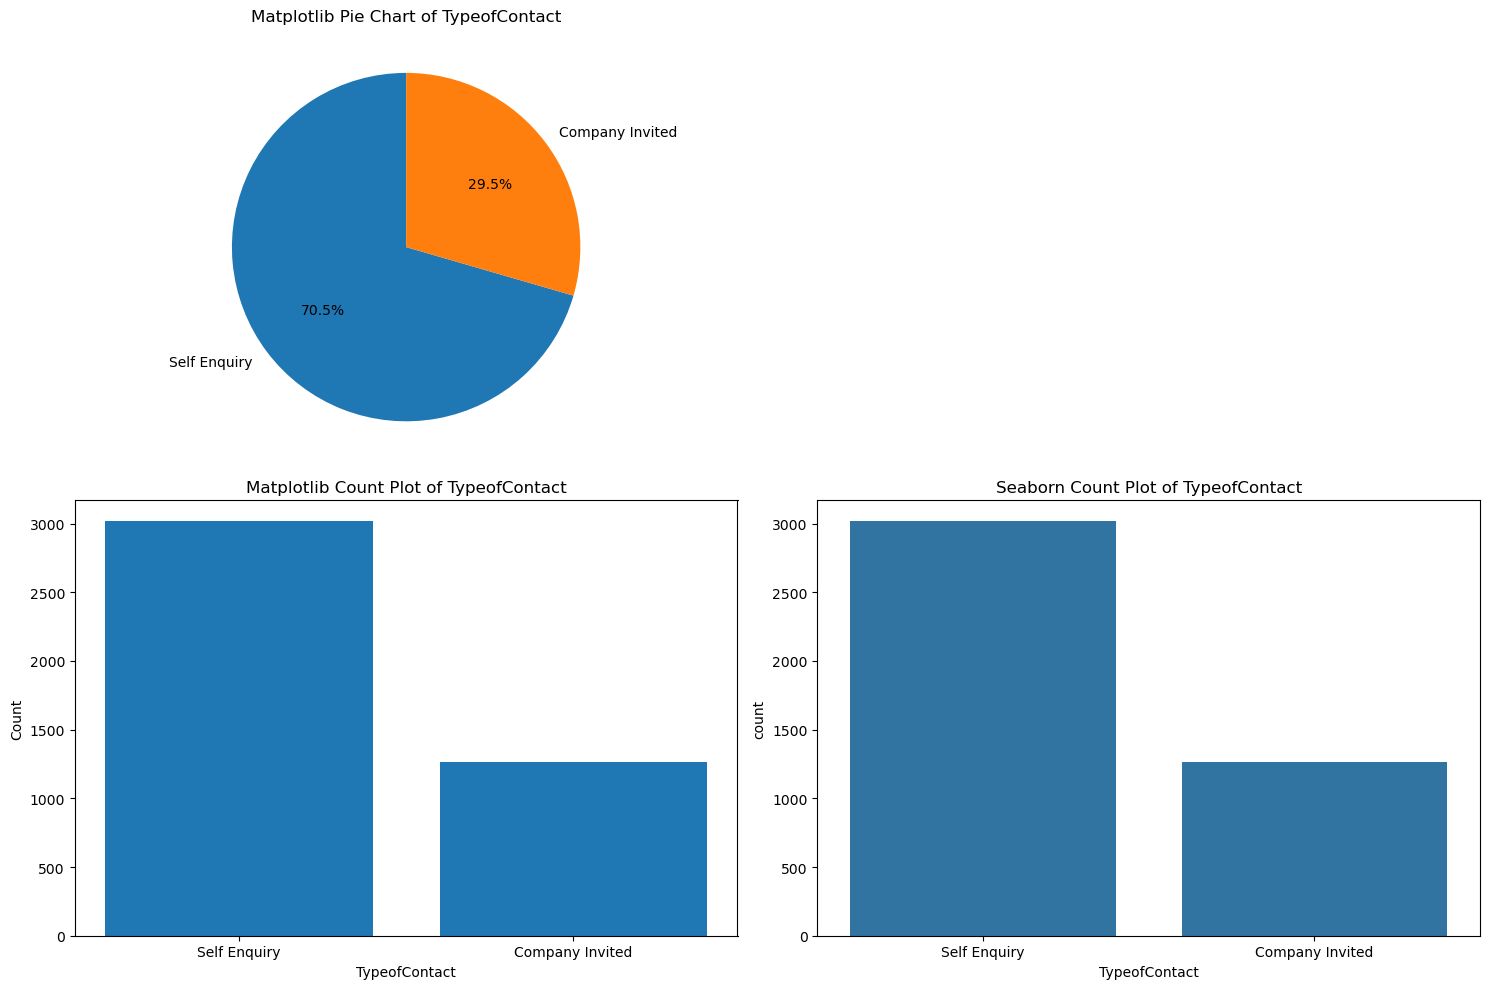

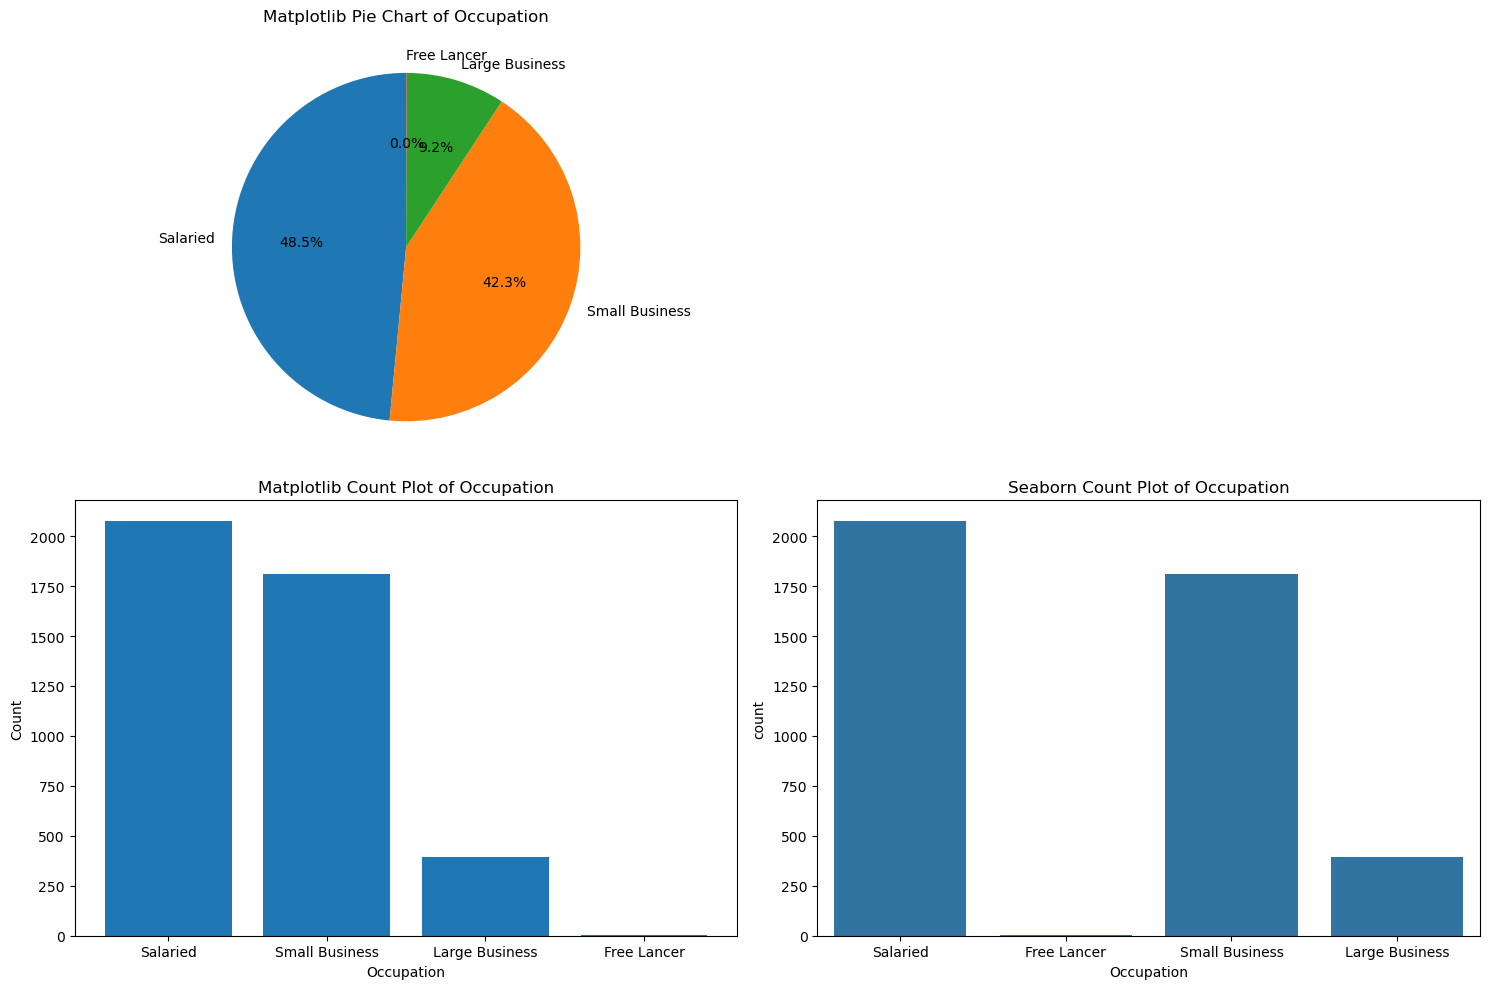

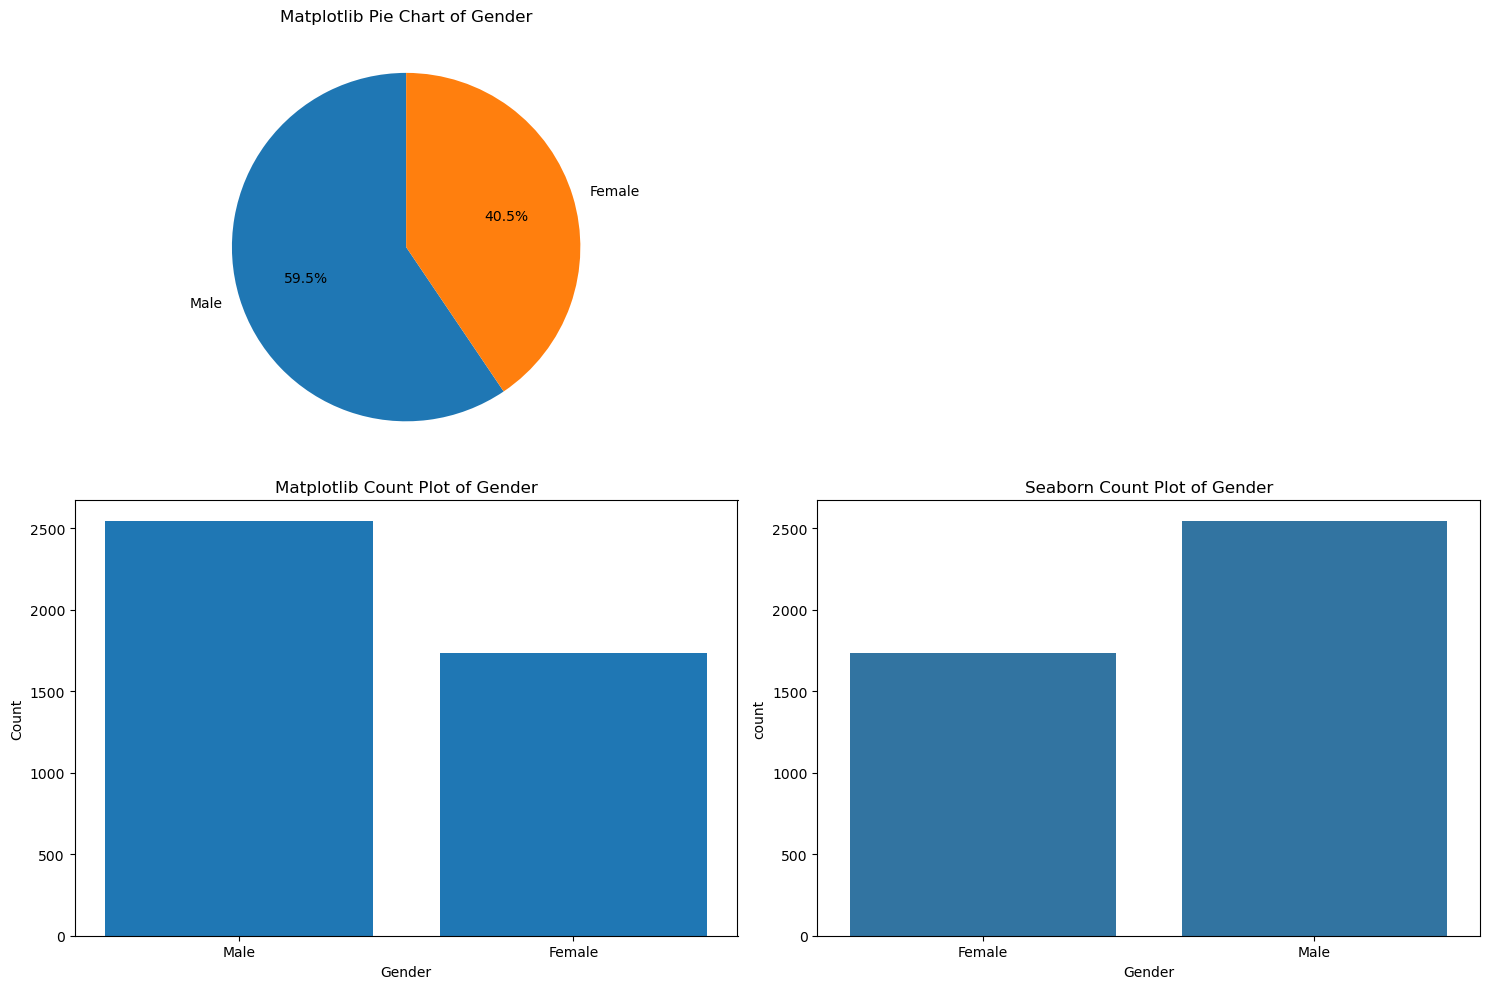

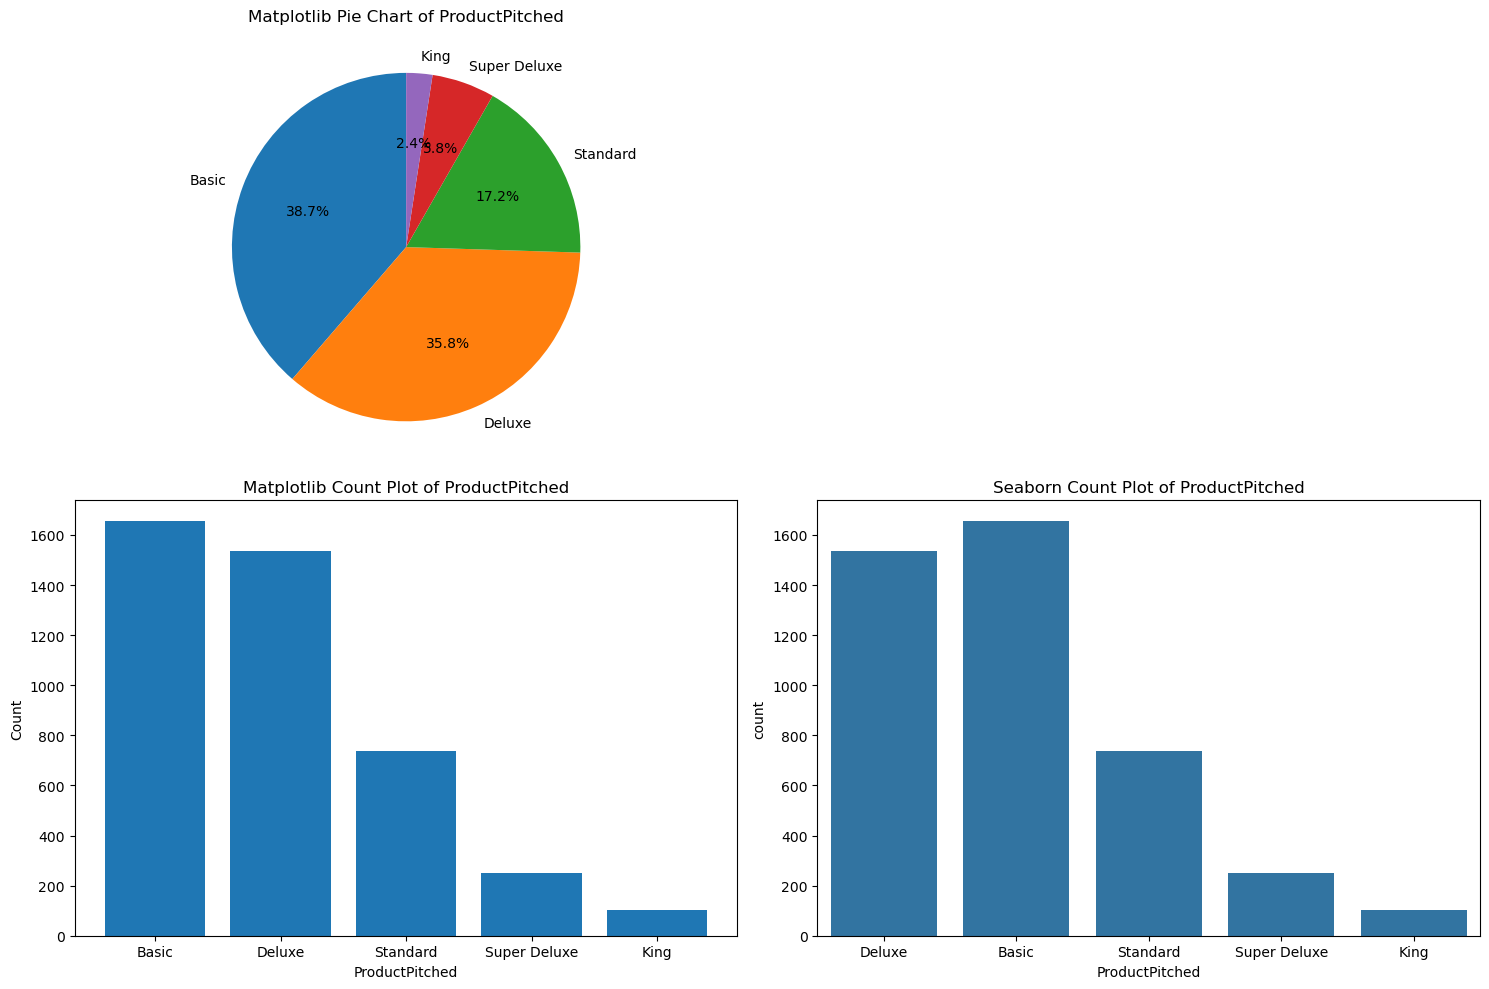

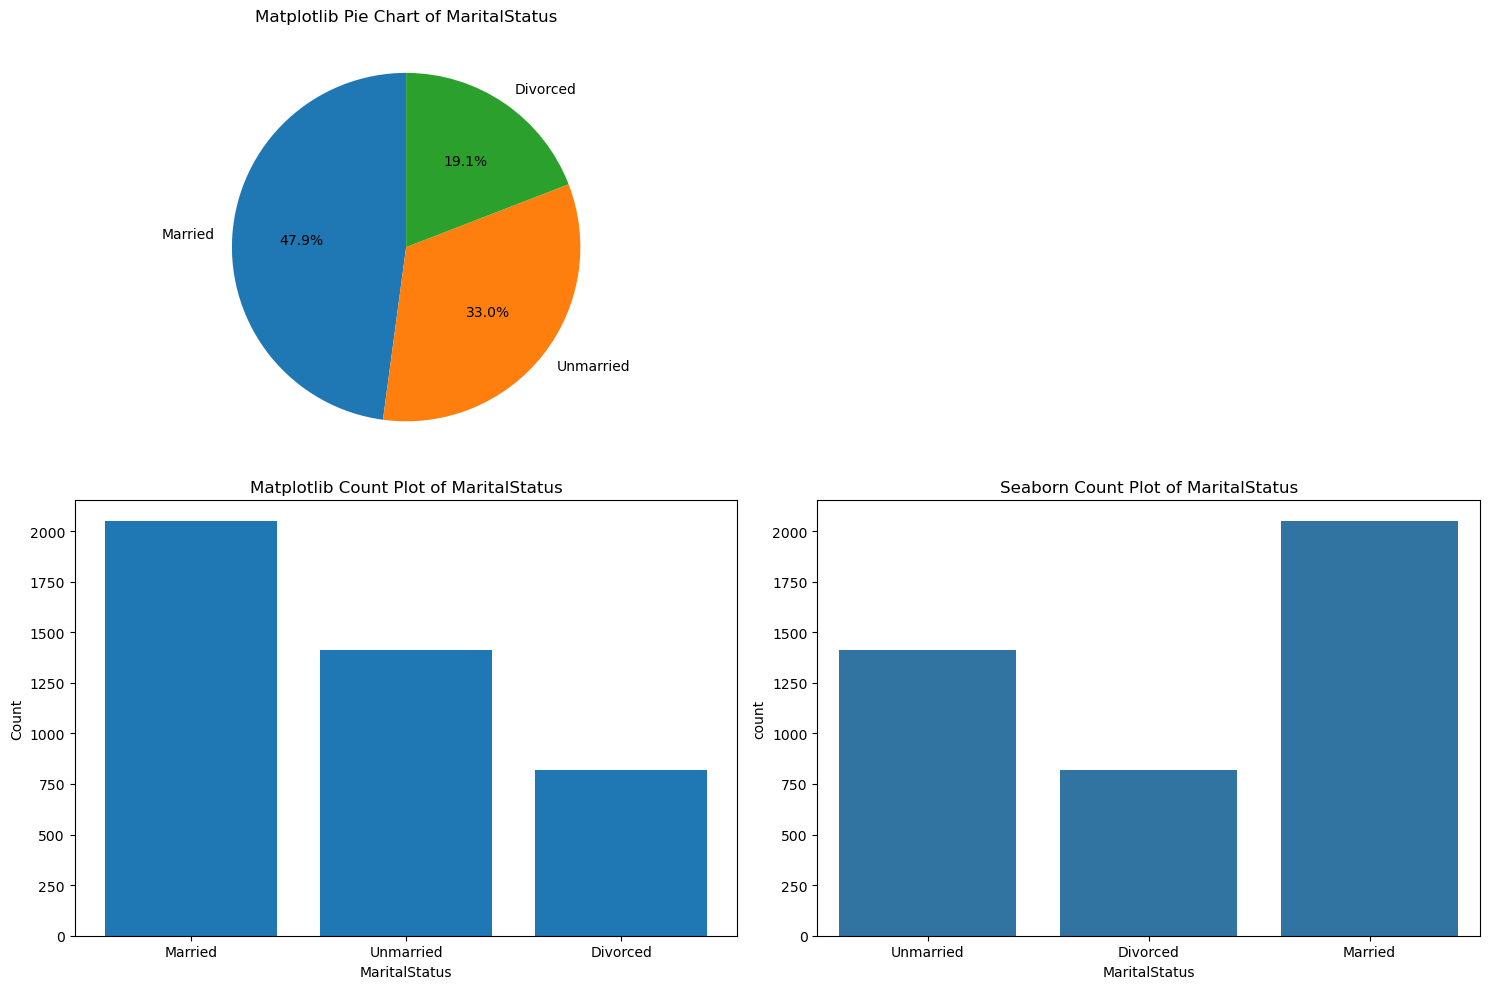

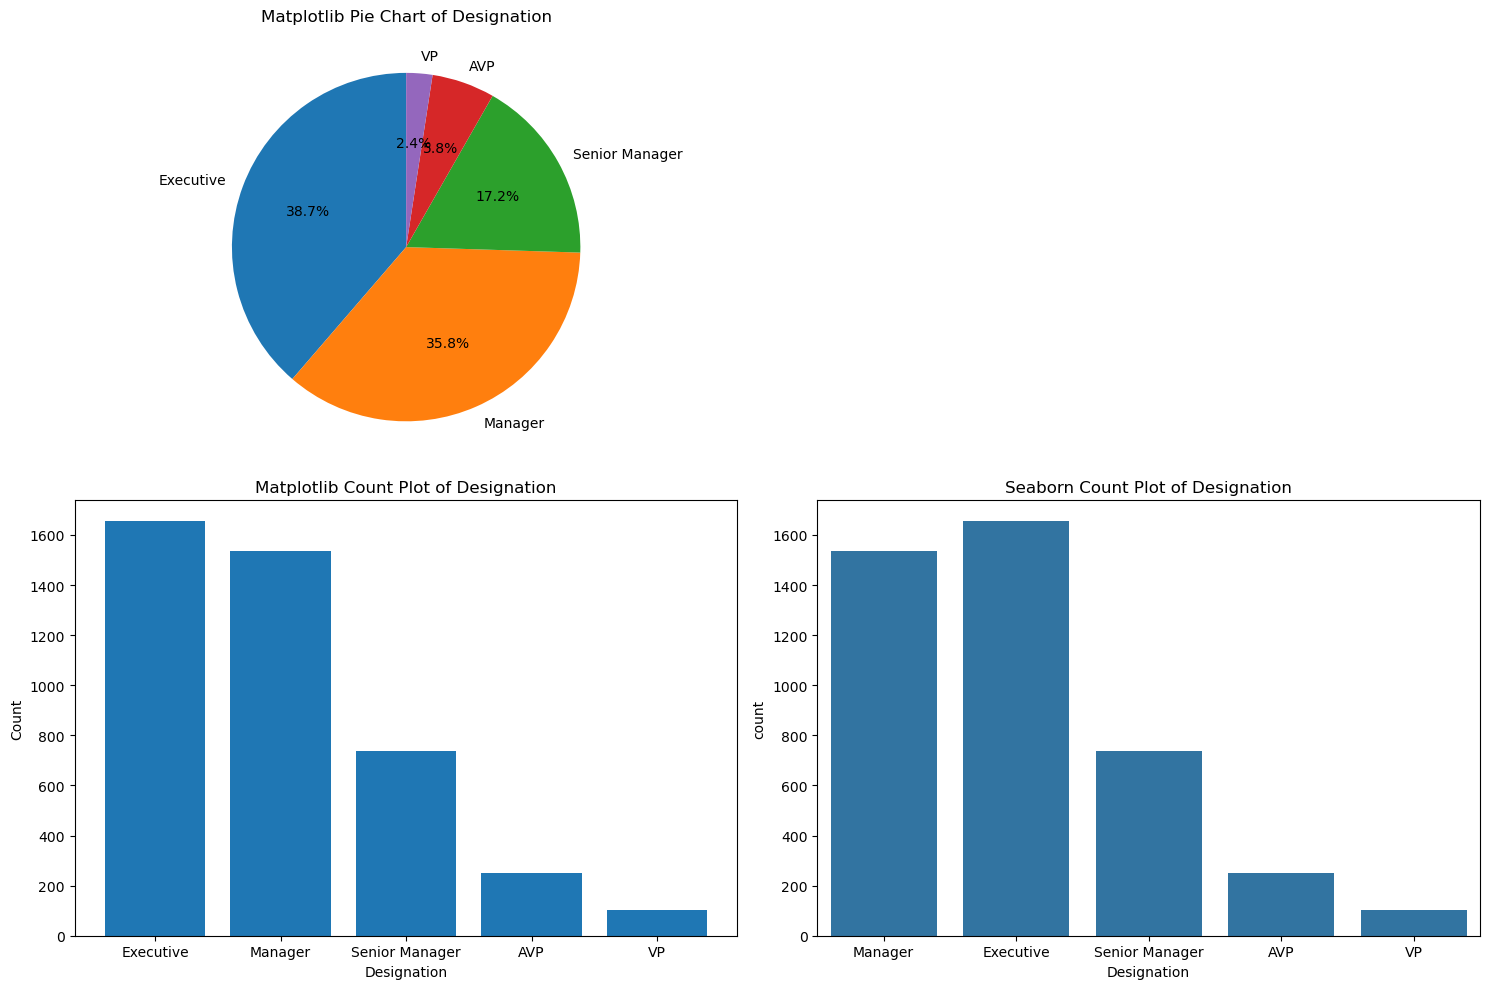

In [34]:
# Assuming the lists cont_cols, disc_cols, and cat_cols are already defined

# Function to plot univariate plots
def plot_univariate(df, cont_cols, disc_cols, cat_cols):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # # Plot for continuous columns
    # for col in cont_cols:
    #     plt.figure(figsize=(20, 30))

    #     # Histogram using Matplotlib
    #     plt.subplot(3, 2, 1)
    #     plt.hist(df[col], bins=30, color='skyblue', edgecolor='black')
    #     plt.title(f'Matplotlib Histogram of {col}')
    #     plt.xlabel(col)
    #     plt.ylabel('Frequency')

    #     # Histogram using Seaborn
    #     plt.subplot(3, 2, 2)
    #     sns.histplot(df[col], bins=30, color='skyblue', kde=True)
    #     plt.title(f'Seaborn Histogram of {col}')

    #     # Boxplot using Matplotlib
    #     plt.subplot(3, 2, 3)
    #     plt.boxplot(df[col])
    #     plt.title(f'Matplotlib Boxplot of {col}')
    #     plt.xlabel(col)

    #     # Boxplot using Seaborn
    #     plt.subplot(3, 2, 4)
    #     sns.boxplot(x=df[col])
    #     plt.title(f'Seaborn Boxplot of {col}')

    #     # Violin plot using Matplotlib
    #     plt.subplot(3, 2, 5)
    #     plt.violinplot(df[col])
    #     plt.title(f'Matplotlib Violin Plot of {col}')
    #     plt.xlabel(col)

    #     # Violin plot using Seaborn
    #     plt.subplot(3, 2, 6)
    #     sns.violinplot(x=df[col])
    #     plt.title(f'Seaborn Violin Plot of {col}')

    #     plt.tight_layout()
    #     plt.show()

    # # Plot for discrete columns
    # for col in disc_cols:
    #     plt.figure(figsize=(15, 5))

    #     # Count plot using Matplotlib
    #     plt.subplot(1, 2, 1)
    #     plt.bar(df[col].value_counts().index, df[col].value_counts().values)
    #     plt.title(f'Bar Plot of {col}')
    #     plt.xlabel(col)
    #     plt.ylabel('Count')

    #     # Count plot using Seaborn
    #     plt.subplot(1, 2, 2)
    #     sns.countplot(x=col, data=df)
    #     plt.title(f'Count Plot of {col}')

    #     plt.tight_layout()
    #     plt.show()

    # Plot for categorical columns
    for col in cat_cols:
        plt.figure(figsize=(15, 10))

        # Pie chart using Matplotlib
        plt.subplot(2, 2, 1)
        plt.pie(df[col].value_counts(),labels=df[col].value_counts().index,autopct='%1.1f%%',startangle=90)
        plt.title(f'Matplotlib Pie Chart of {col}')
        plt.ylabel('')

        # Count plot using Matplotlib
        plt.subplot(2, 2, 3)
        plt.bar(df[col].value_counts().index, df[col].value_counts().values)
        plt.title(f'Matplotlib Count Plot of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')

        # Count plot using Seaborn
        plt.subplot(2, 2, 4)
        sns.countplot(x=col, data=df)
        plt.title(f'Seaborn Count Plot of {col}')

        plt.tight_layout()
        plt.show()

# Call the function
plot_univariate(data, cont_cols, disc_cols, cat_cols)


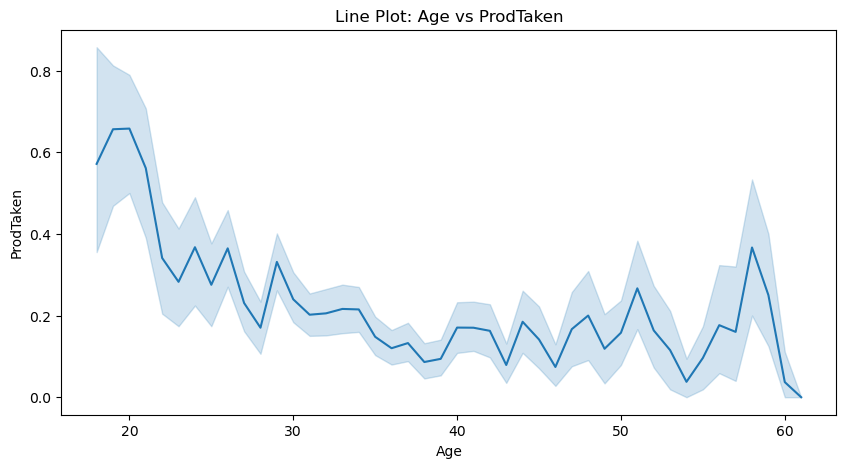

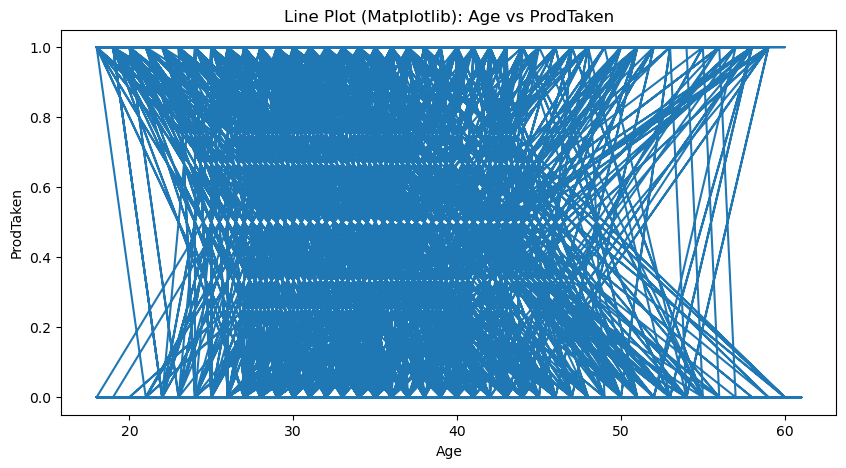

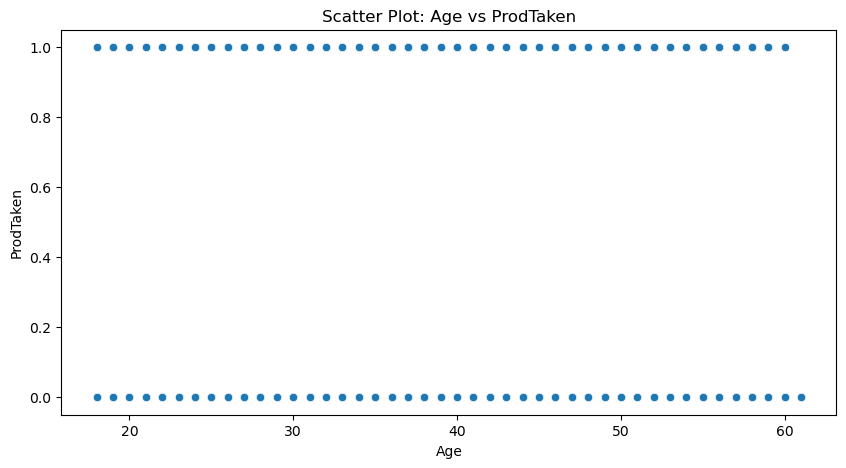

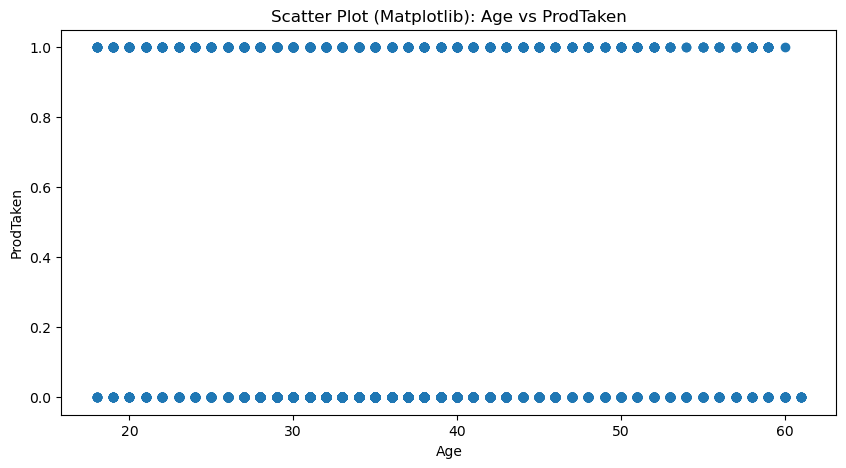

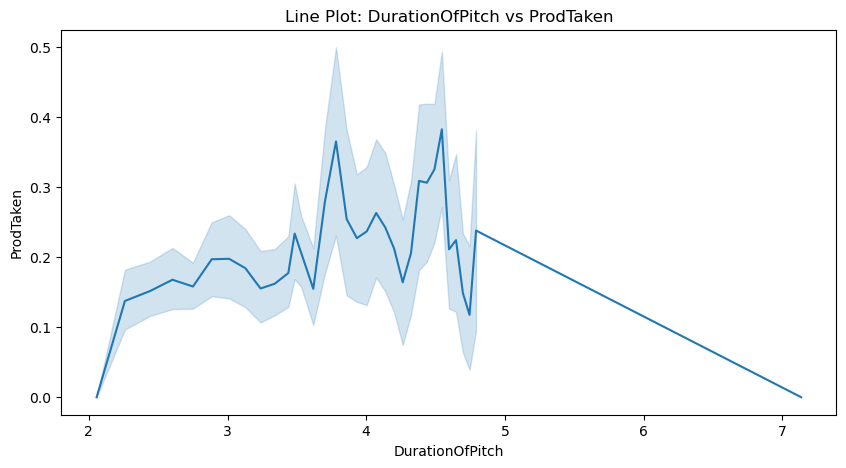

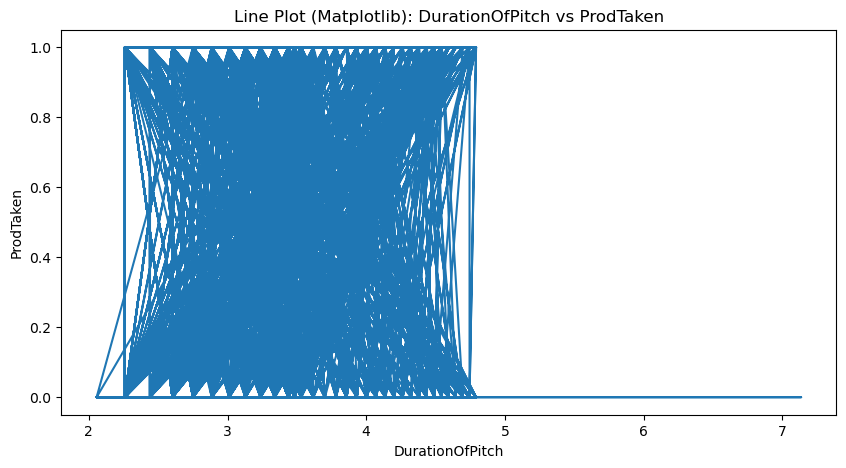

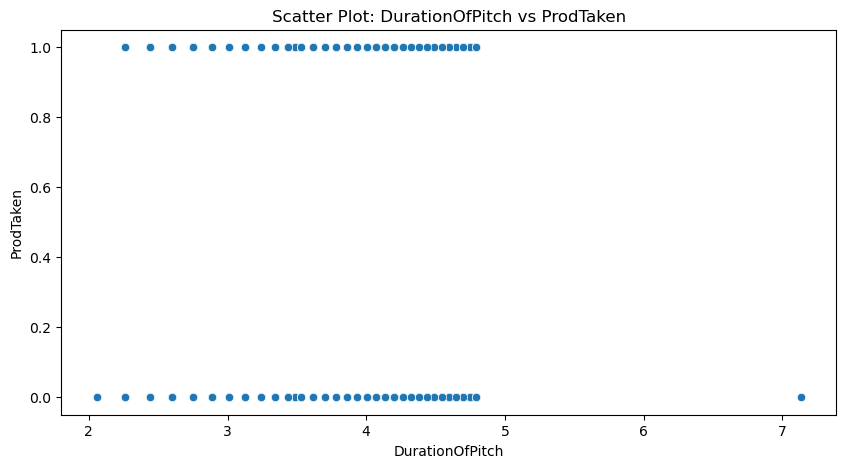

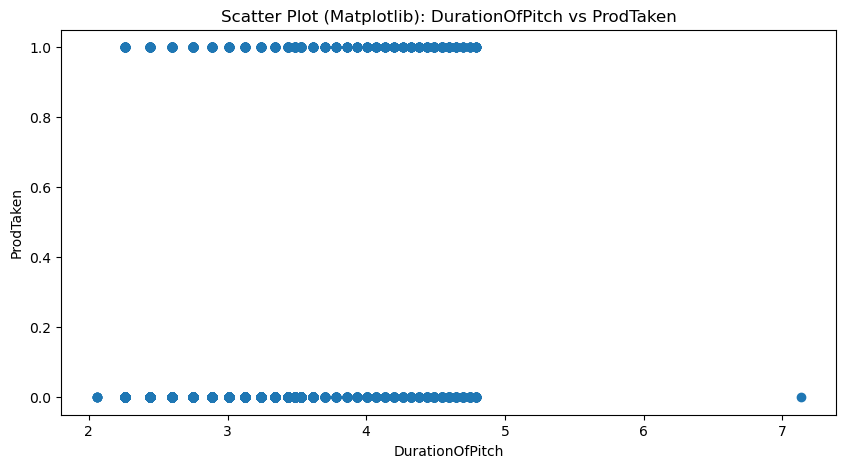

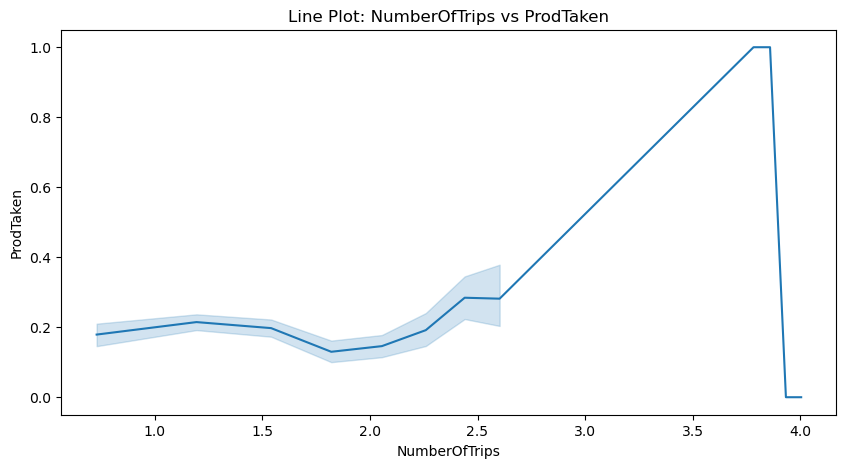

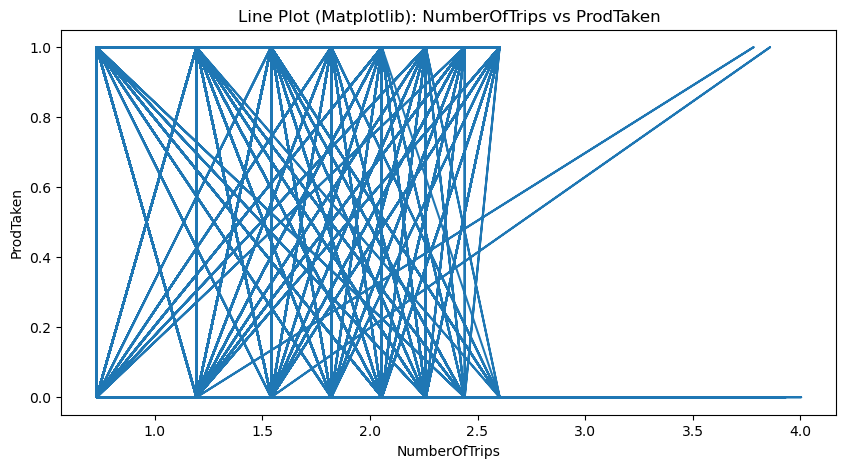

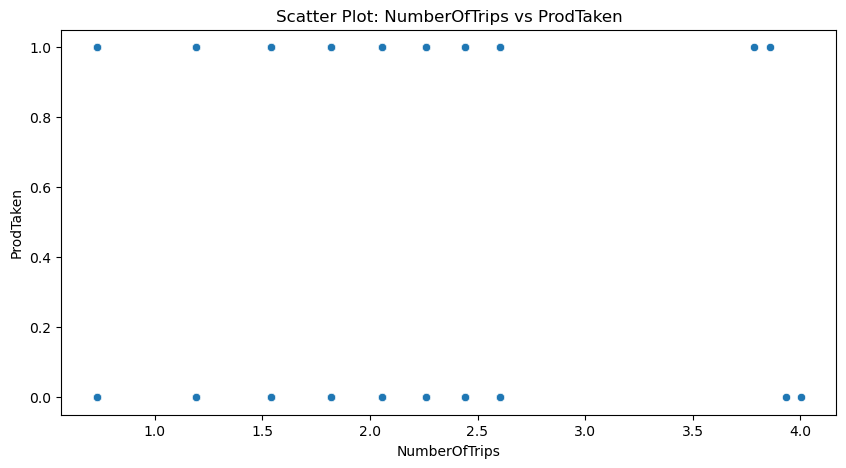

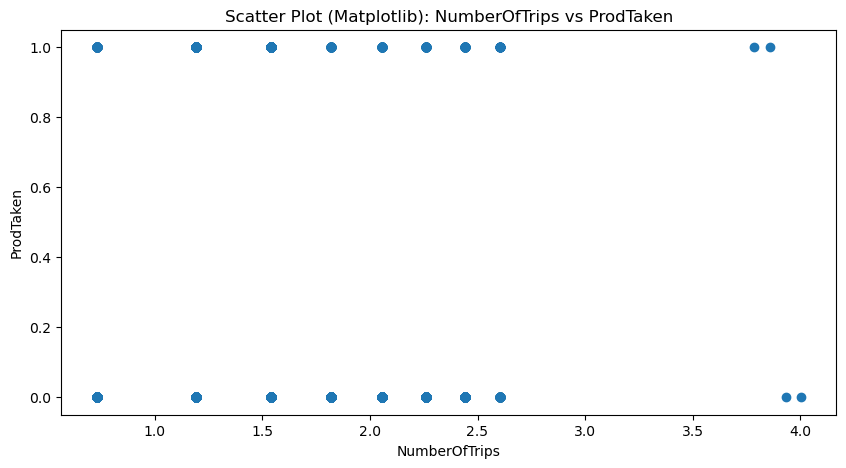

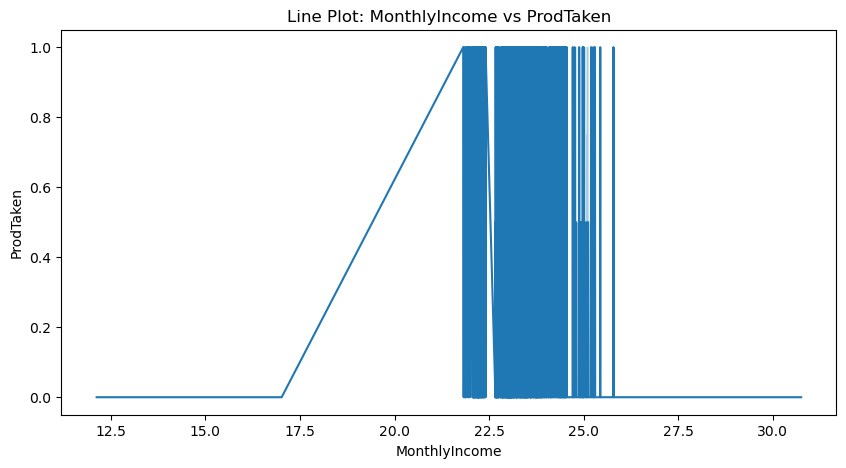

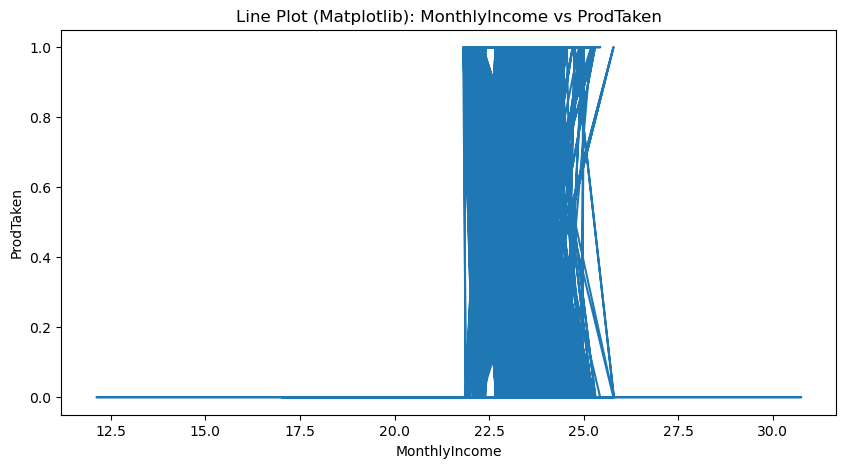

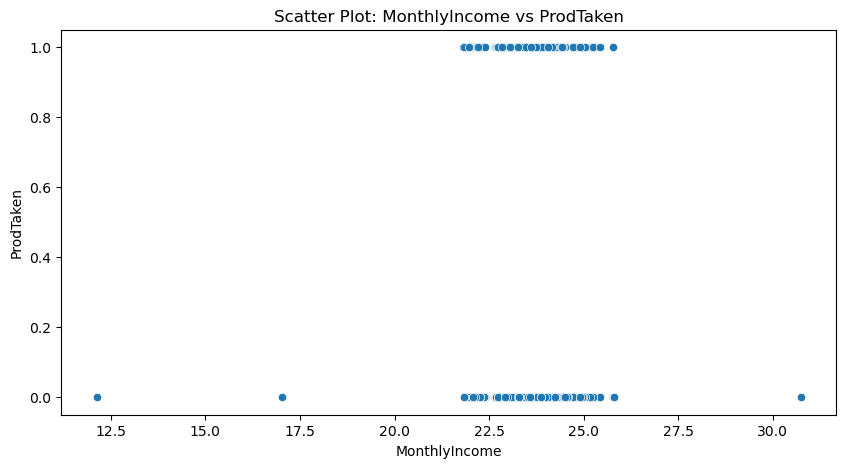

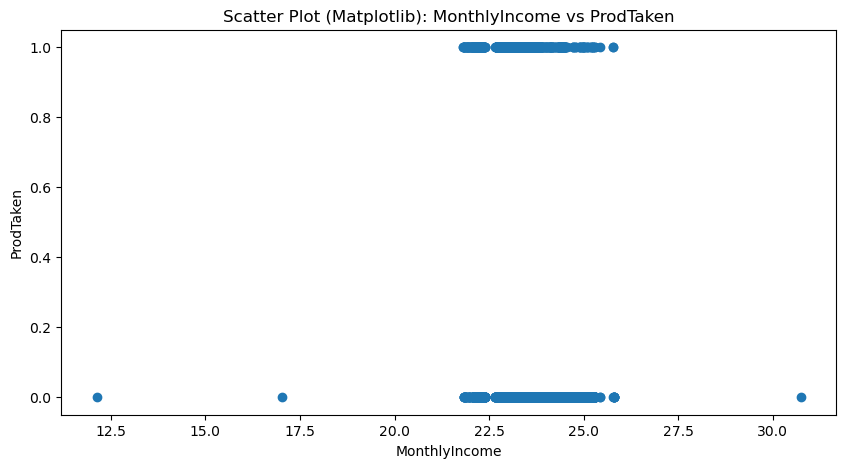

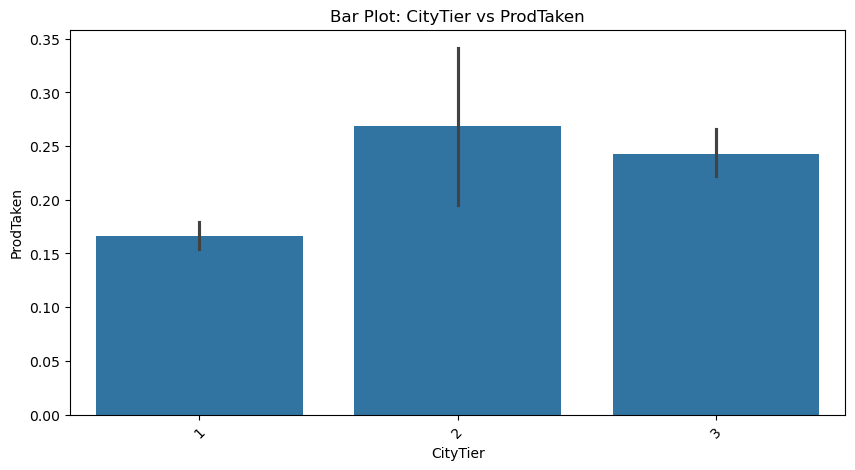

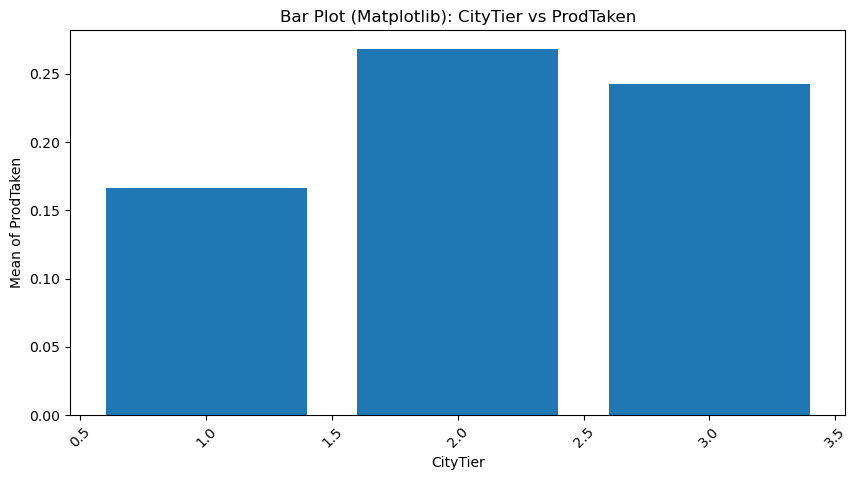

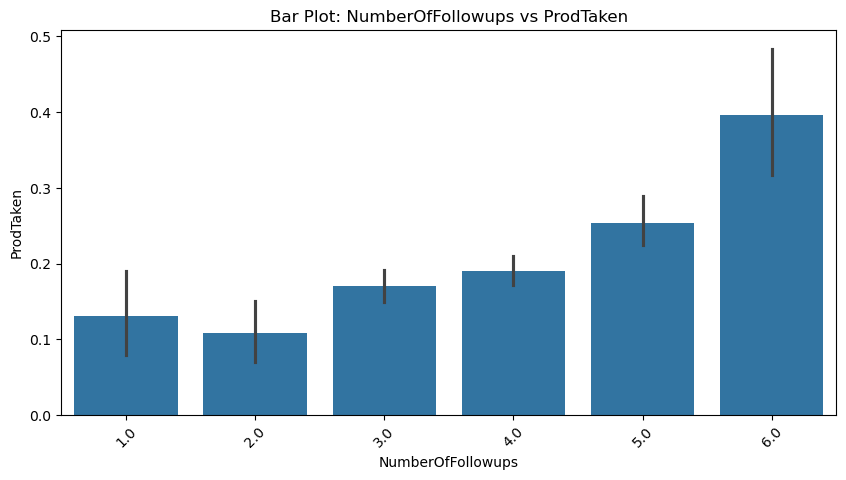

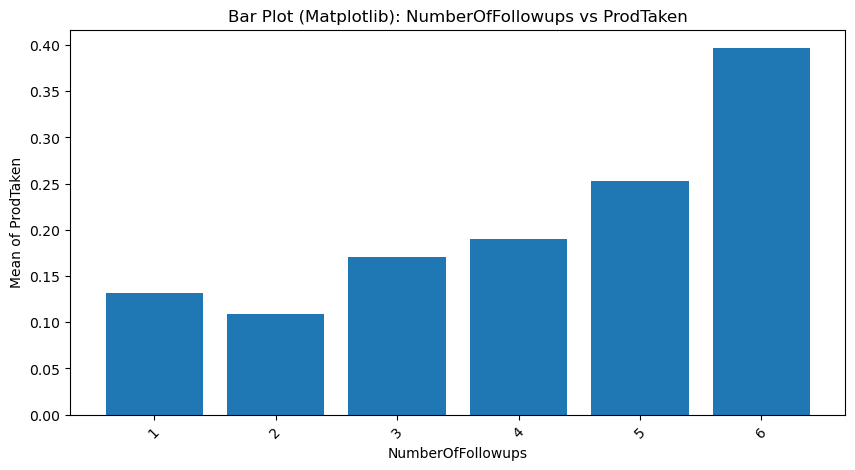

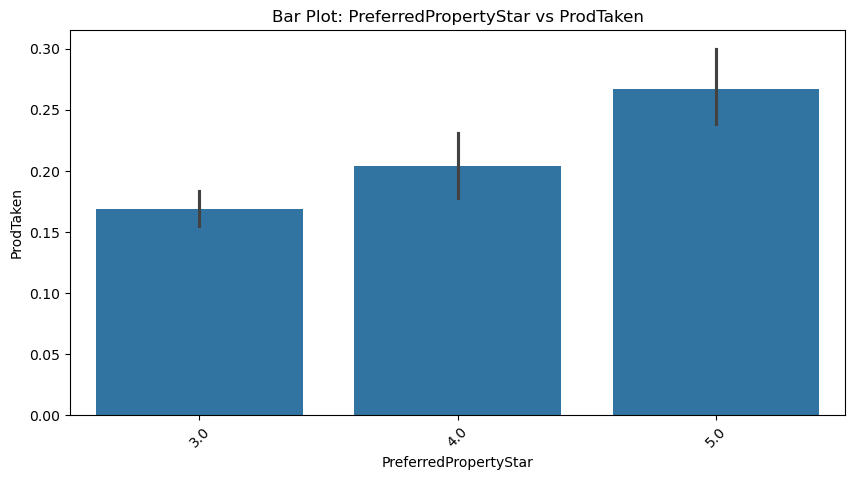

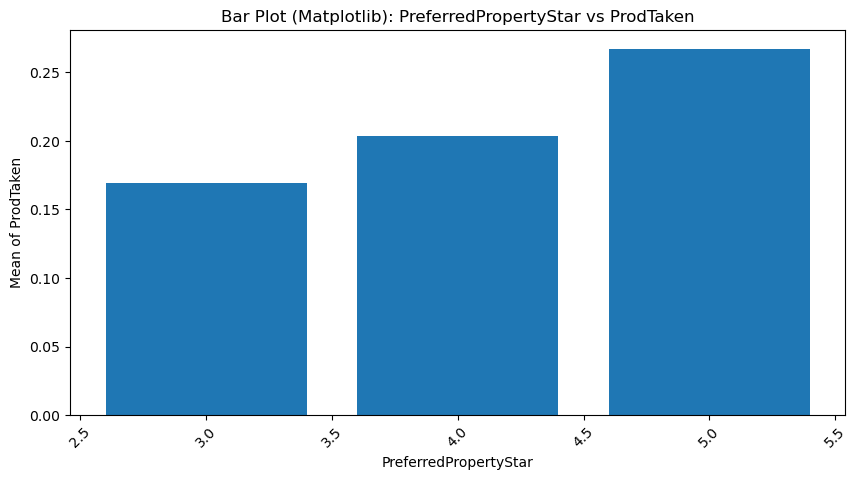

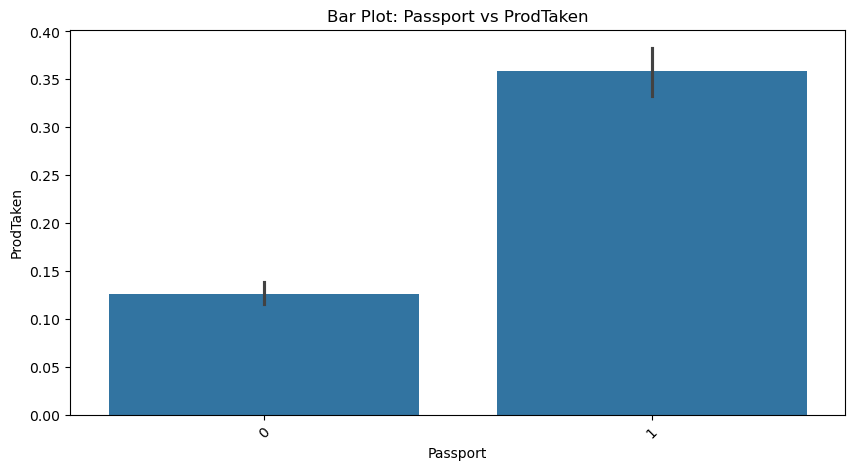

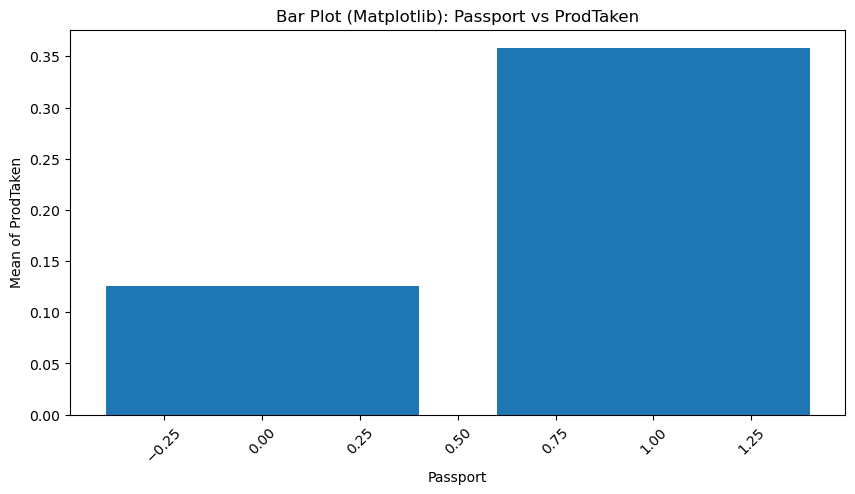

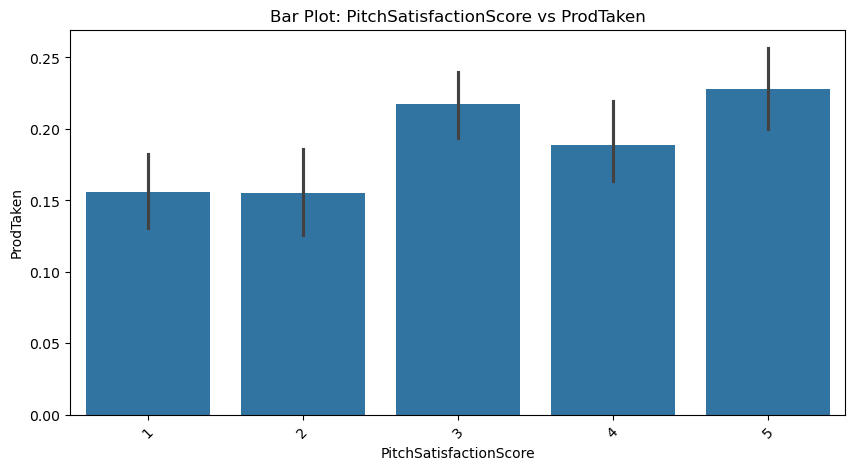

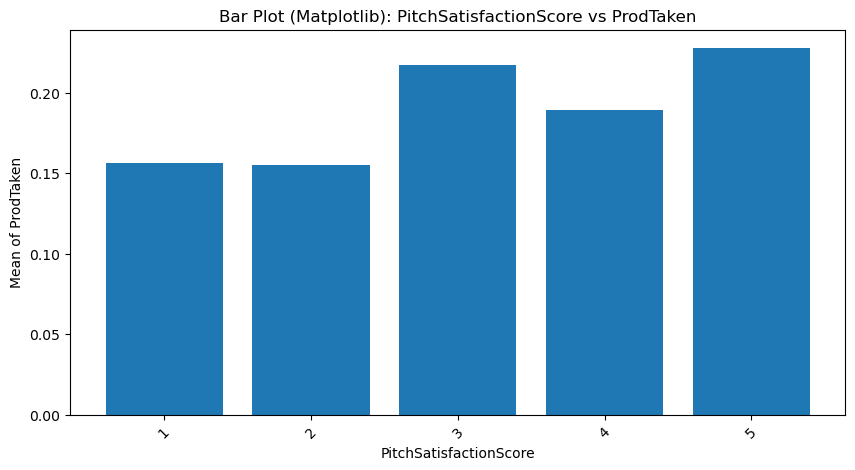

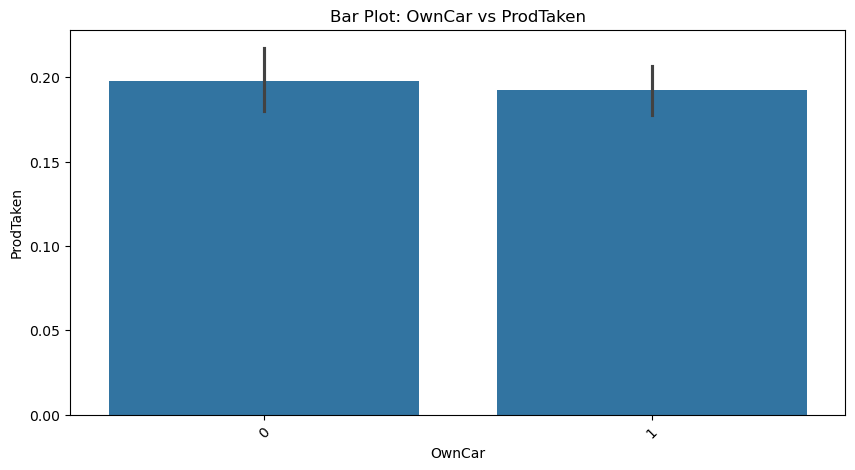

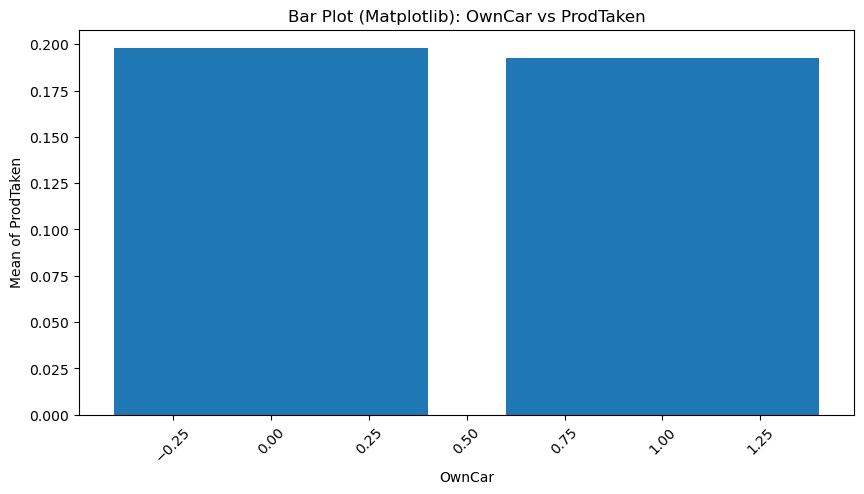

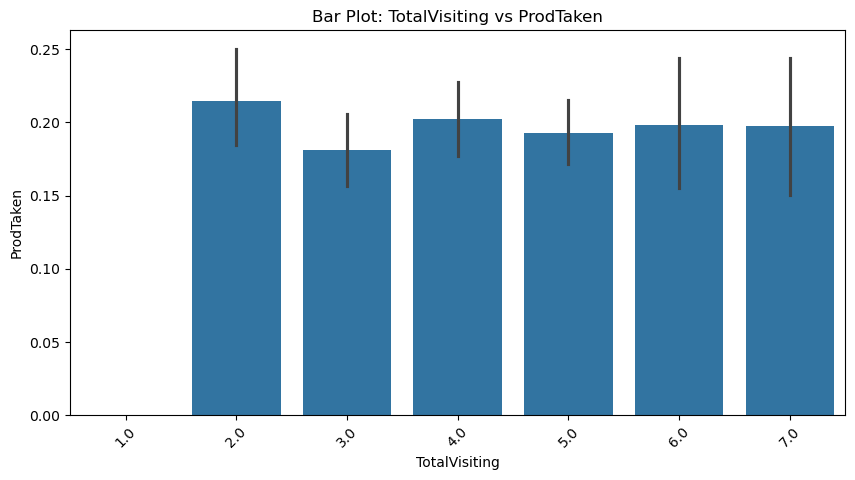

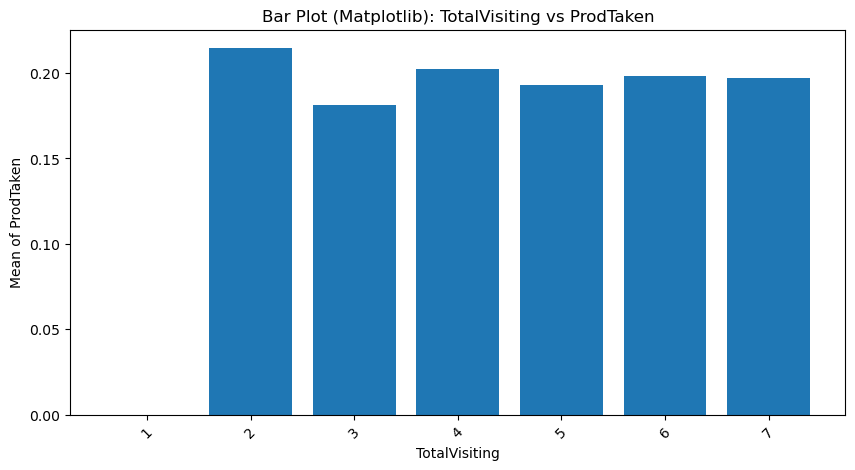

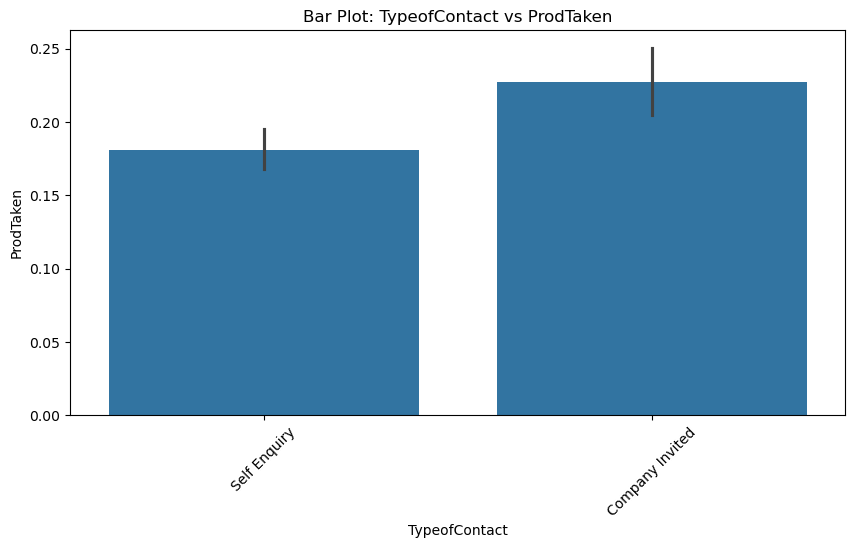

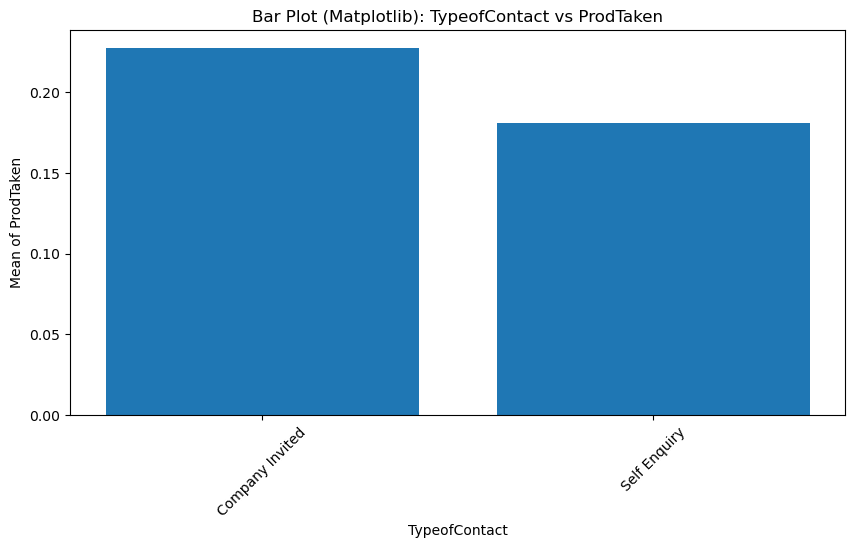

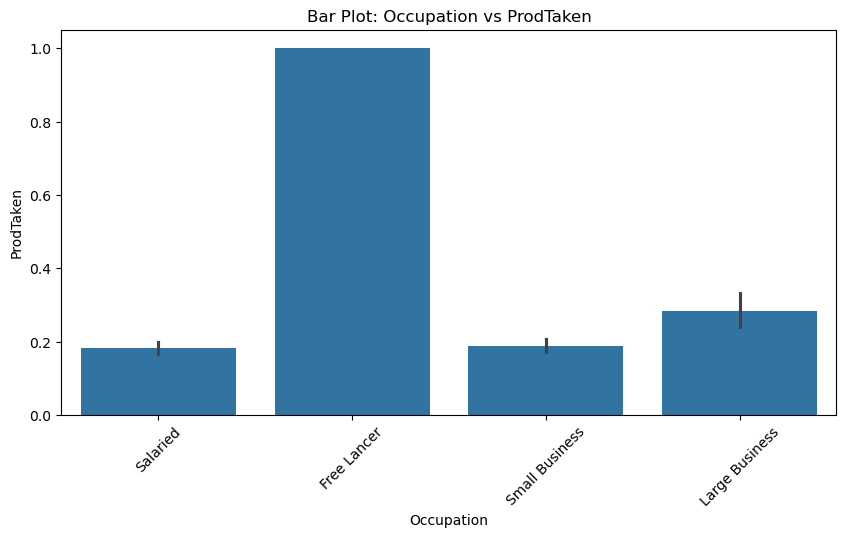

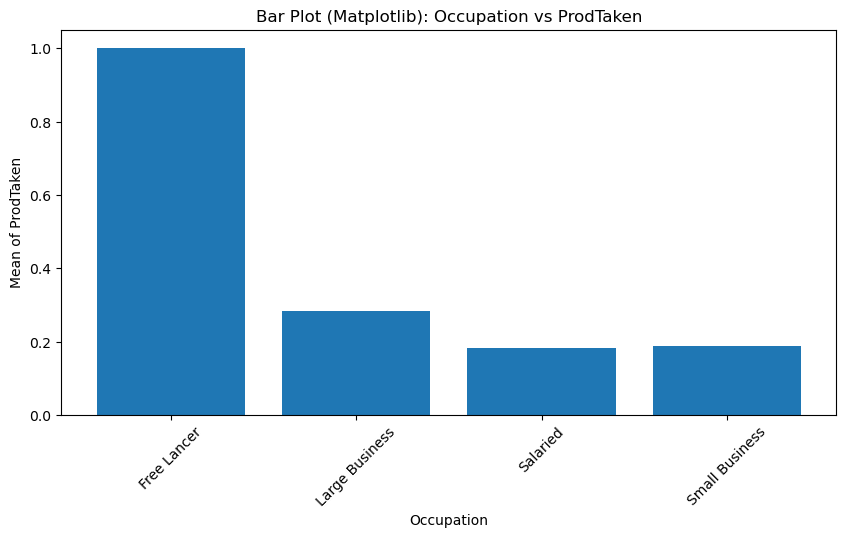

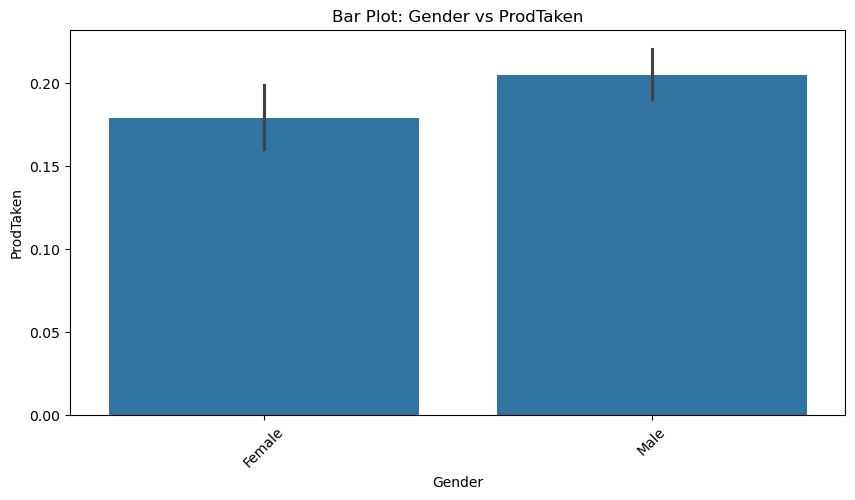

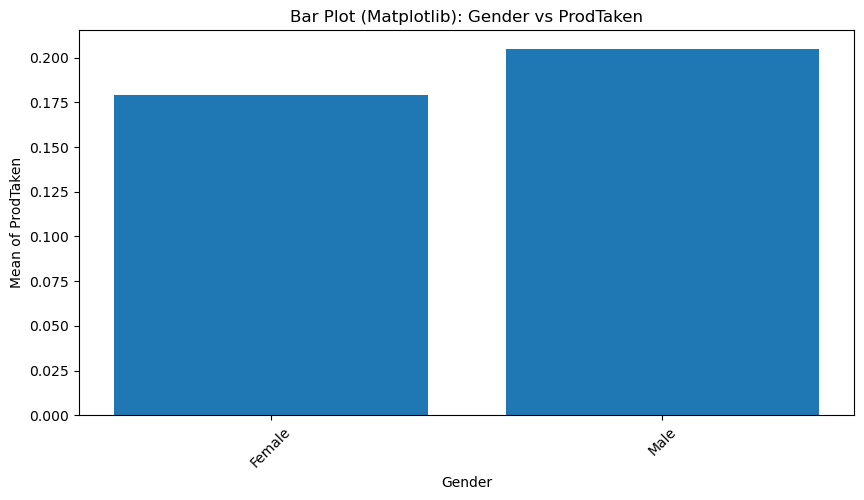

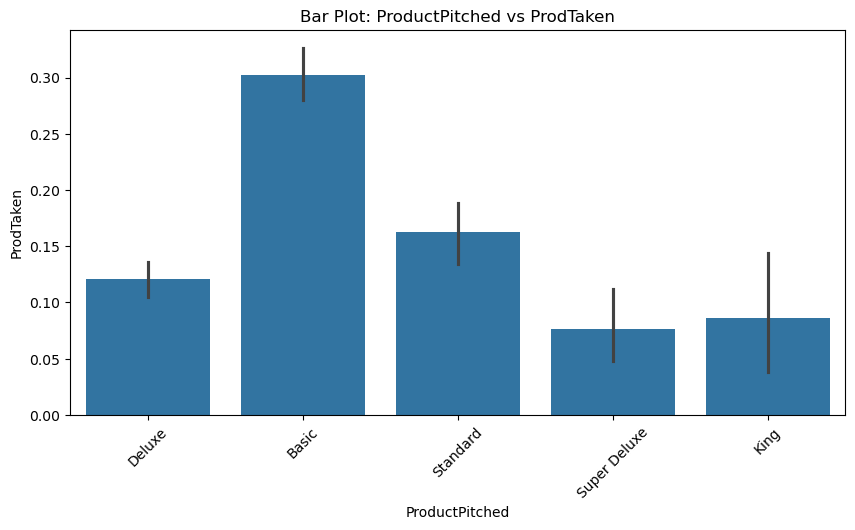

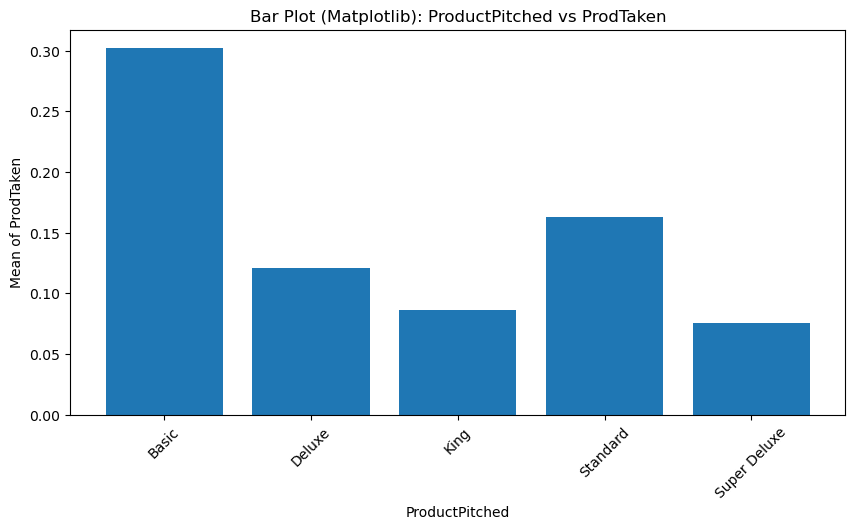

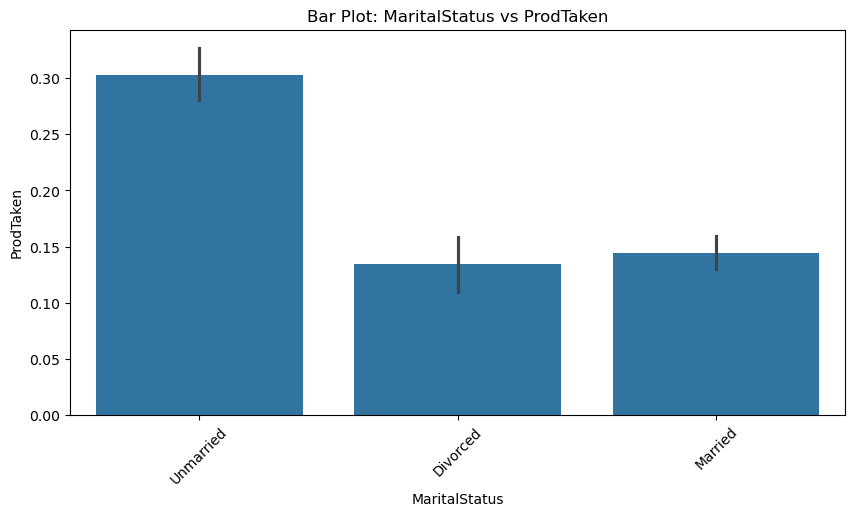

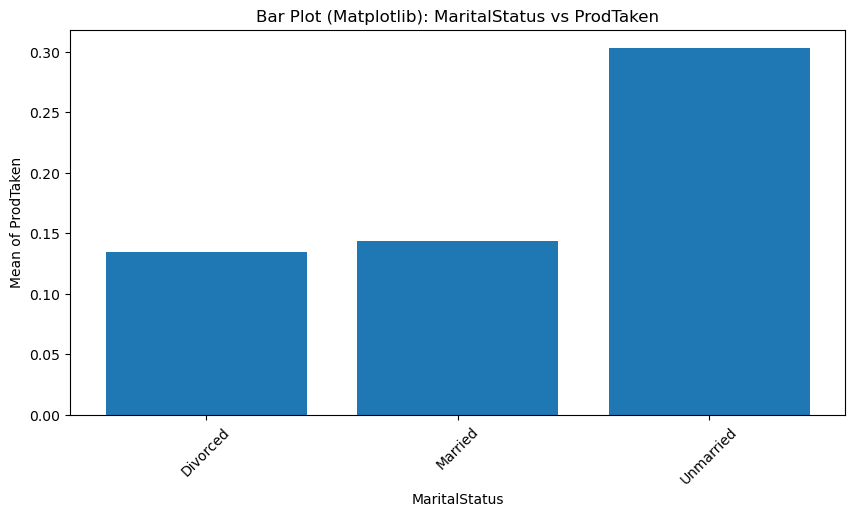

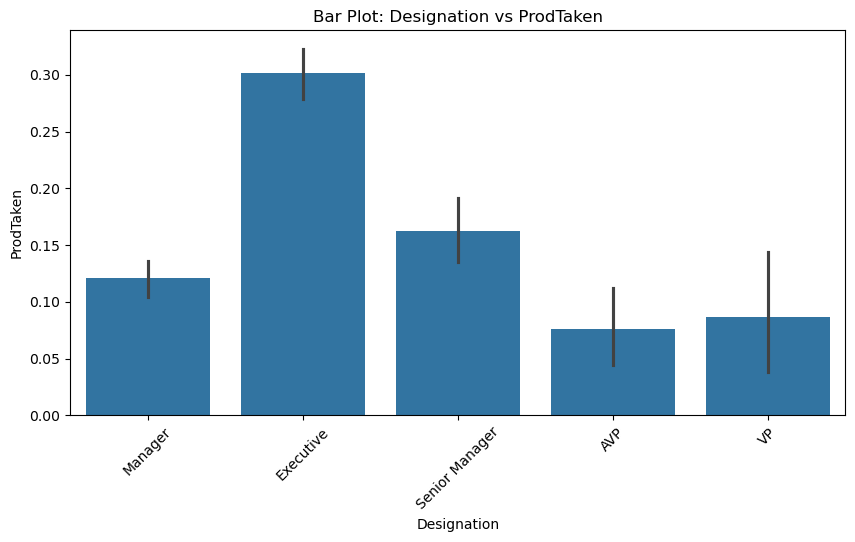

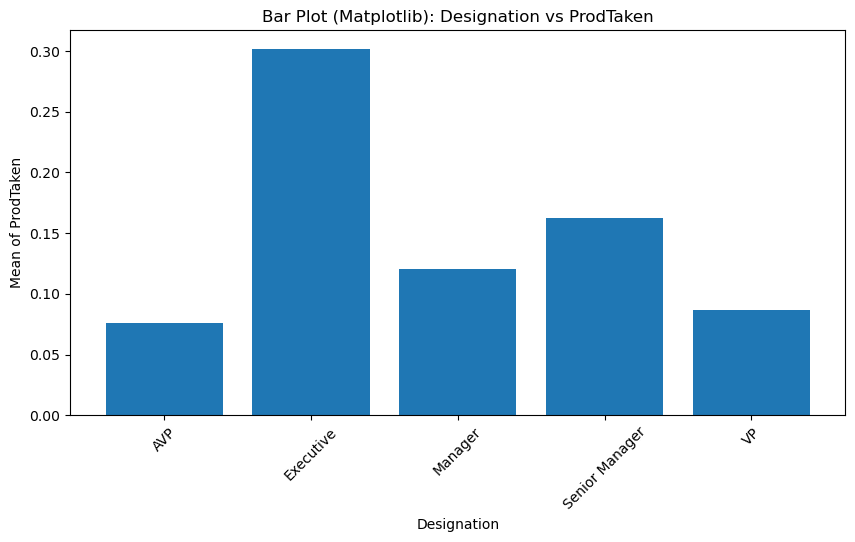

In [35]:
df = data
target = 'ProdTaken'
# Loop through continuous columns to plot relationships
for col in cont_cols:
    # Line plot
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=df[col], y=df[target])
    plt.title(f"Line Plot: {col} vs {target}")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(df[col], df[target])
    plt.title(f"Line Plot (Matplotlib): {col} vs {target}")
    plt.xlabel(col)
    plt.ylabel(target)
    plt.show()

    # Scatter plot
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=df[col], y=df[target])
    plt.title(f"Scatter Plot: {col} vs {target}")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.scatter(df[col], df[target])
    plt.title(f"Scatter Plot (Matplotlib): {col} vs {target}")
    plt.xlabel(col)
    plt.ylabel(target)
    plt.show()

# Loop through discrete and categorical columns to plot relationships
for col in list(disc_cols) + list(cat_cols):
    # Bar plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=df[col], y=df[target], estimator='mean')
    plt.title(f"Bar Plot: {col} vs {target}")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.bar(df.groupby(col)[target].mean().index, df.groupby(col)[target].mean().values)
    # df.groupby(col)[target].mean().plot(kind='bar', color='orange', edgecolor='black')
    plt.title(f"Bar Plot (Matplotlib): {col} vs {target}")
    plt.xlabel(col)
    plt.ylabel(f"Mean of {target}")
    plt.xticks(rotation=45)
    plt.show()


<Figure size 1000x1000 with 0 Axes>

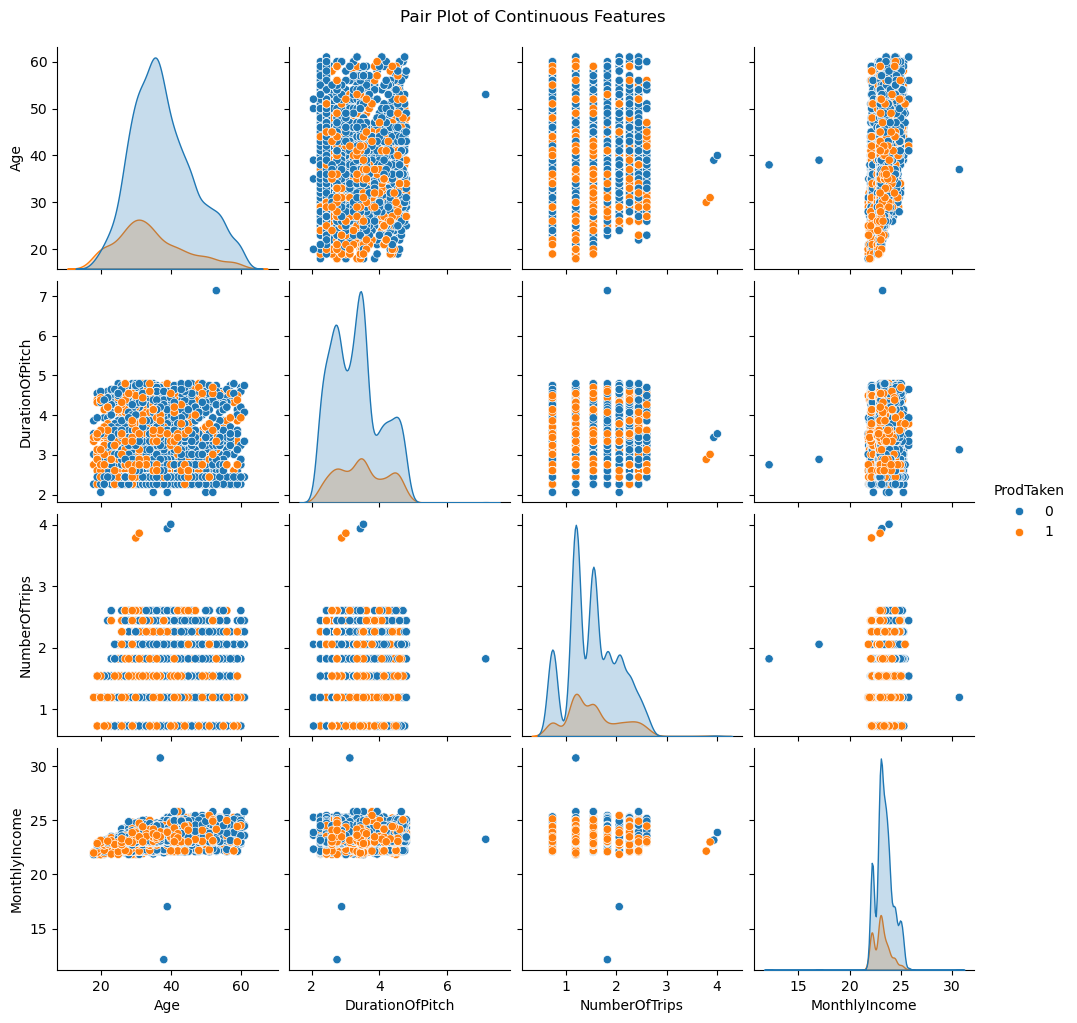

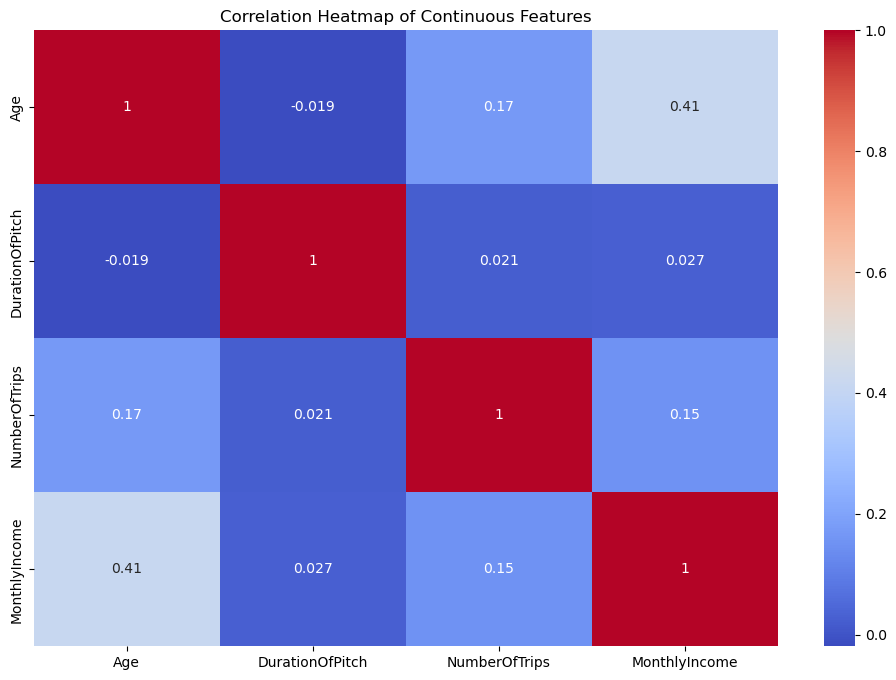

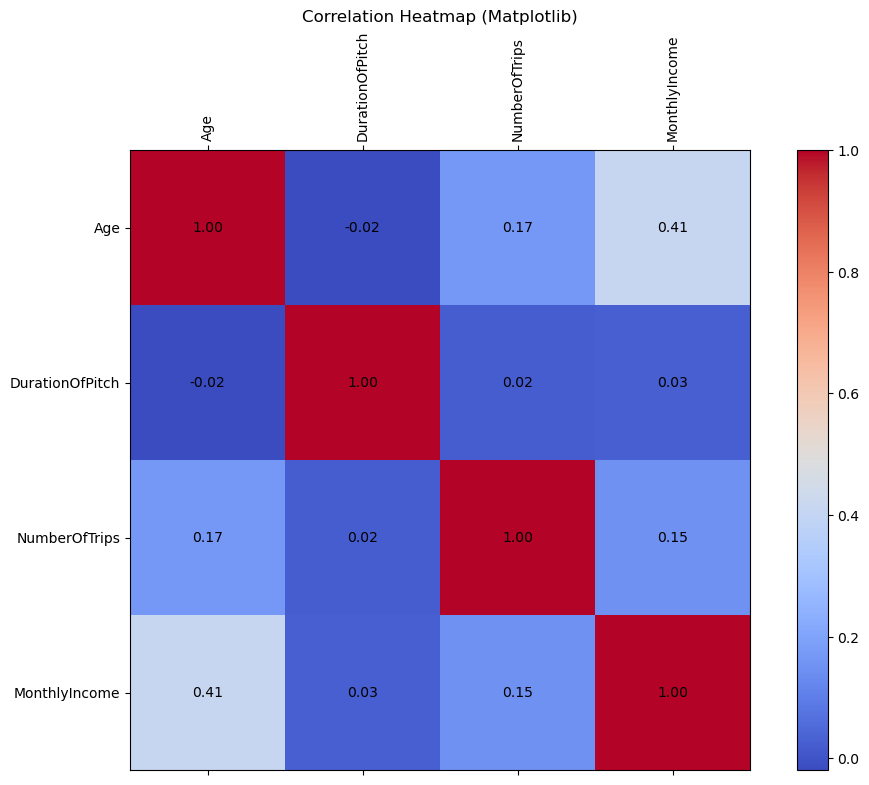

In [36]:
# Multivariate Plots
# Pair Plot
plt.figure(figsize=(10, 10))
sns.pairplot(df[cont_cols + [target]], hue=target)
plt.suptitle("Pair Plot of Continuous Features", y=1.02)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df[cont_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Continuous Features")
plt.show()

plt.figure(figsize=(12, 8))
corr_matrix = df[cont_cols].corr()
plt.matshow(corr_matrix, fignum=1, cmap="coolwarm")
plt.colorbar()
plt.xticks(range(len(cont_cols)), labels=cont_cols, rotation=90)
plt.yticks(range(len(cont_cols)), labels=cont_cols)
plt.title("Correlation Heatmap (Matplotlib)")

# Adding annotations in the heatmap
for (i, j), val in np.ndenumerate(corr_matrix):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

plt.show()


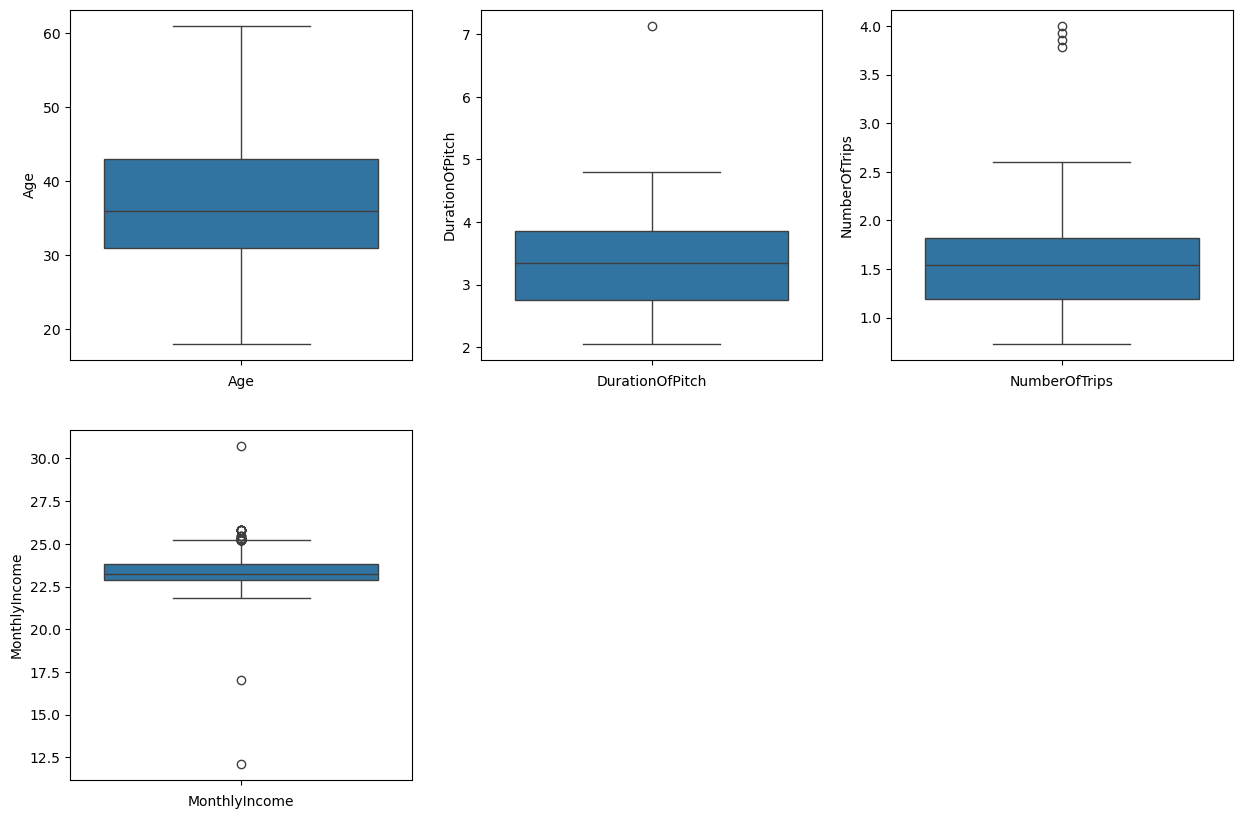

In [37]:
# Boxplots for numerical features
plt.figure(figsize=(15, 10))   
num_features = len(cont_cols)
rows = (num_features // 3) + (num_features % 3 > 0)
for i, feature in enumerate(cont_cols, 1):
    plt.subplot(rows, 3, i)
    sns.boxplot(data[feature])
    plt.xlabel(feature)

Age: Most of the data lies between 30-50 years, with some outliers beyond this range.

CityTier: There seems to be limited variation in the values, suggesting that most data points belong to a similar tier.

DurationOfPitch: The pitch duration appears to be concentrated around 3-5 units, with some extreme outliers.

NumberOfTrips: This feature has a fairly consistent distribution with some outliers.

MonthlyIncome: There's a large spread, with some high-income outliers, indicating income variability among individuals.

Passport, OwnCar: These features have a high concentration of data near 0.2-0.7 for passport ownership and close to 0 for car ownership, with a few outliers.


In [38]:
# Detecting and handling outliers using IQR for numerical columns only
Q1 = data[cont_cols].quantile(0.25)
Q3 = data[cont_cols].quantile(0.75)
IQR = Q3 - Q1

# Create a boolean mask for outlier detection
outlier_mask = ((data[cont_cols] < (Q1 - 1.5 * IQR)) | (data[cont_cols] > (Q3 + 1.5 * IQR))).any(axis=1)

# Use the boolean mask to filter the DataFrame
data = data[~outlier_mask.values]



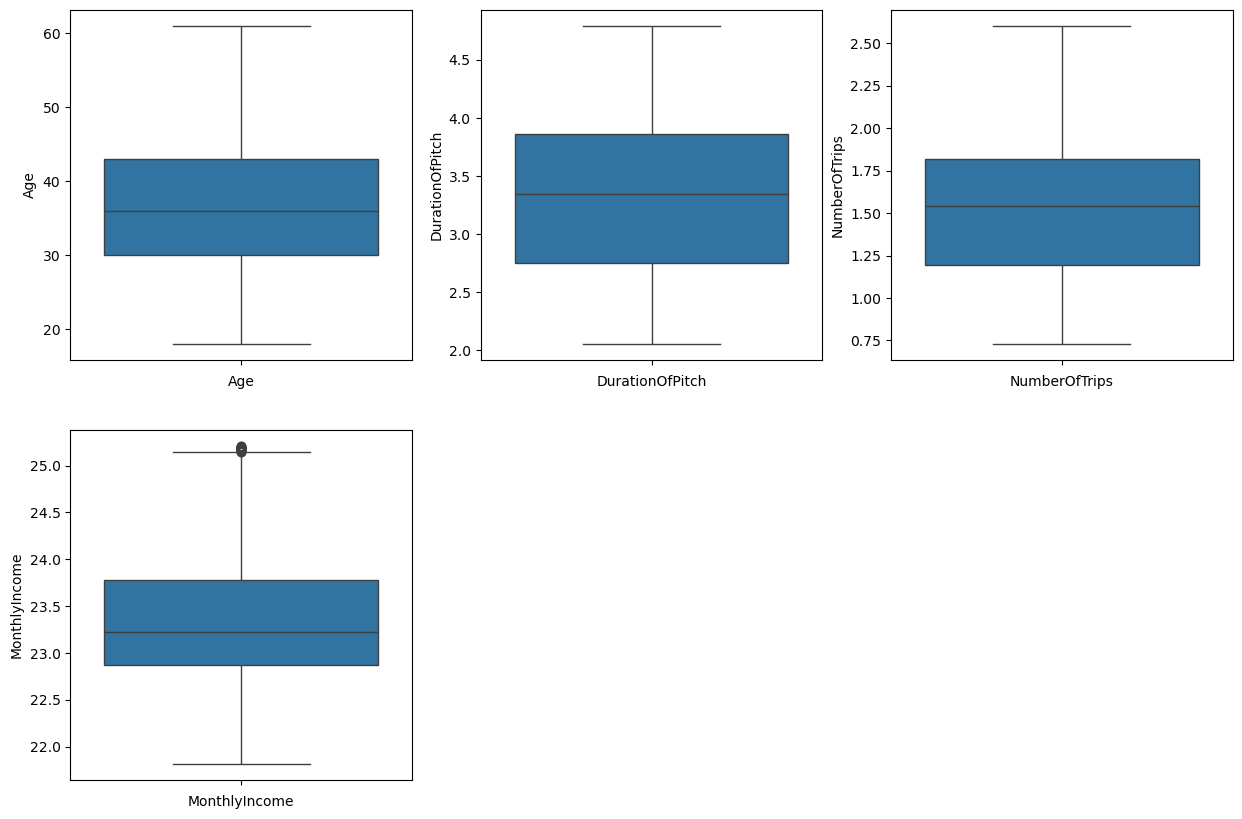

In [39]:
# Boxplots for numerical features
plt.figure(figsize=(15, 10))   
num_features = len(cont_cols)
rows = (num_features // 3) + (num_features % 3 > 0)
for i, feature in enumerate(cont_cols, 1):
    plt.subplot(rows, 3, i)
    sns.boxplot(data[feature])
    plt.xlabel(feature)

Age follows a nearly normal distribution, indicating the dataset predominantly consists of middle-aged individuals.

CityTier and Gender are categorical, with one or two categories being highly dominant.

NumberOfTrips, MonthlyIncome, and PitchDuration exhibit right-skewed distributions, suggesting a concentration of lower values with fewer high-value outliers.

The PreferredPropertyStar and ProductPitched attributes seem categorical with well-defined peaks, indicating distinct preferences.

1. Type of Contact


    Self Enquiry: A significant portion of individuals who did not take the product falls under "Self Enquiry," while fewer individuals who took the product belong to this category.

    Company Invited: Individuals invited by the company seem more likely to take the product compared to those in the "Self Enquiry" group.


2. Occupation

    Salaried: Most individuals, irrespective of whether they took the product or not, belong to the "Salaried" category. However, the conversion rate (those who took the product) is slightly higher compared to other groups.

    Small Business: This group has a moderate number of individuals, but the conversion rate is lower than for "Salaried."

    Freelancer & Large Business: These have a smaller overall population, and conversion is minimal.


3. Gender

    Male: Males form the majority of the total population, and a higher number took the product compared to females.

    Female: Although fewer females are in the dataset, their conversion rate is proportionally lower.


4. Product Pitched

    Deluxe and Basic: These two categories dominate both in terms of total interest and conversions.

    Standard, Super Deluxe, and King: These products have fewer overall interest and conversions, suggesting they may not appeal as much to the audience.


5. Marital Status

    Married: Most of the population is married, and this group also has the highest number of product conversions.

    Unmarried & Divorced: These groups have fewer individuals overall and show a lower conversion rate.


6. Designation

    Manager: This group has the largest population, but the conversion rate is modest compared to the total size.

    Executives and Senior Managers: These have a moderate representation, with some conversions.

    AVP (Assistant Vice President) & VP (Vice President): These groups have minimal representation and conversions.

Strong Positive Correlations:

    Age and MonthlyIncome (0.41):

        Older individuals tend to have higher monthly incomes. This is a notable correlation that could influence decisions around target demographics for marketing or sales strategies.

    NumberOfFollowups and NumberOfTrips (0.16):

        Higher follow-ups are moderately correlated with the number of trips, suggesting that consistent communication might be associated with more travel or engagement.

    CityTier and MonthlyIncome (0.12):

        Individuals in higher-tier cities seem to have slightly higher incomes, which may reflect economic opportunities in urban areas.

Moderate Positive Correlations:

    NumberOfTrips and MonthlyIncome (0.18):

        People with higher incomes tend to travel more, indicating a potential market segment for premium products or services related to travel.

    OwnCar and PitchSatisfactionScore (0.073):

        Car ownership is weakly correlated with satisfaction from the pitch, possibly reflecting a certain socio-economic demographic being more responsive.

Weak or Insignificant Correlations:

    DurationOfPitch and Most Variables:

        The duration of the pitch shows weak correlations across the board, indicating that the length of engagement doesn’t strongly influence other factors.

    PreferredPropertyStar:

        This variable shows almost no meaningful correlation with other factors, suggesting that preference for property stars may be more personal or unrelated to measurable demographics.

    Passport and Other Variables:

        Passport ownership has minimal correlation with the other variables, indicating it’s not a significant factor in this dataset.

Negative or Near-Zero Correlations:
    
    Age and PreferredPropertyStar (-0.027):
    
        Older individuals do not significantly prefer higher or lower property star ratings.
    
    CityTier and PreferredPropertyStar (-0.019):
    
        The property star preference also shows no substantial link with city tier, suggesting uniform preferences across different urban levels.

In [45]:
X = data.drop(['ProdTaken'], axis=1)  # features  
y = data['ProdTaken'] # target variable

In [46]:
# Identify categorical and numeric columns
# categorical_cols = X.select_dtypes(include=['object']).columns
# numeric_cols = X.select_dtypes(exclude=['object']).columns

# Define a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cont_cols),       # Scale numeric columns
        ('cat', OneHotEncoder(drop='first'), cat_cols)  # Encode categorical columns
    ]
)

# Apply the transformations
X_transformed = preprocessor.fit_transform(X)

# Ensure the target variable is numeric (optional, for consistency)
y = y.astype(int)

In [47]:
X_transformed.shape

(4193, 19)

In [48]:
# Before applying SMOTE
print("Before SMOTE:")
print(f"Class distribution: {Counter(y)}")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)

# After applying SMOTE
print("\nAfter SMOTE:")
print(f"Class distribution: {Counter(y_resampled)}")

Before SMOTE:
Class distribution: Counter({0: 3371, 1: 822})

After SMOTE:
Class distribution: Counter({1: 3371, 0: 3371})


SMOTE has oversampled the minority class (1) by synthetically generating new instances, making both classes equal in size. This balanced dataset ensures that the model receives equal attention to both classes during training, improving its ability to predict the minority class.

This will result in better recall and precision for the minority class, which is critical in applications like fraud detection, medical diagnoses, etc.

Balancing the dataset addresses the bias toward the majority class, ensuring fairer predictions.

In [49]:
# Applying PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_resampled = pca.fit_transform(X_resampled)

Since we are working with SMOTE (Synthetic Minority Over-sampling Technique) for balancing the classes, it’s likely that the original dataset has high-dimensional, possibly noisy features. By applying PCA, you are making the dataset more efficient and easier to handle for modeling after the class imbalance is addressed.

If your feature set is large, using PCA will likely improve computational efficiency by reducing the number of features, leading to faster model training and evaluation, which is crucial in larger datasets or more complex models (such as deep learning).

In this project, which involves predicting whether someone will purchase a holiday package (ProdTaken), using PCA helps in creating a more generalizable model. By focusing on the most significant components and removing noise or less informative features, the model can better identify the key features affecting the prediction.

In [50]:
print("Number of features before PCA:")
print(X_transformed.shape[1])
print("Number of features after PCA")
print(X_resampled.shape[1])

Number of features before PCA:
19
Number of features after PCA
10


In [51]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [52]:
# Define a dictionary of models and their hyperparameters for GridSearchCV
models_and_params = {
    "LogisticRegression": {
        "model": LogisticRegression(),
        "params": {
            "C": [0.1, 1, 5, 10],
            "solver": ["liblinear", "lbfgs"],
        },
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [3, 5, 10, None],
            "min_samples_split": [2, 5, 10],
            "criterion": ["gini", "entropy"],
        },
    },
    "RandomForest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200, 500],
            "max_depth": [5, 10, 15, None],
            "max_features": [5, 8, "auto", "sqrt"],
            "min_samples_split": [2, 5, 10],
        },
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            "loss": ['log_loss', 'deviance', 'exponential'],
            "criterion": ['friedman_mse','mse', 'mae'],
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 10, None],
        },
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0],
            "algorithm": ["SAMME"]  # Explicitly using SAMME to avoid the warning
        },
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric="logloss"),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5],
        },
    },
    "SVM": {
        "model": SVC(probability=True),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf", "poly"],
        },
    },
}


In [53]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define a scorer for GridSearchCV
scorer = make_scorer(f1_score, average="binary")


In [54]:
# Function to evaluate models and print training and testing errors
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Predicting the labels for both training and testing datasets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculating performance metrics for test data
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)
    roc_auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if hasattr(model, "predict_proba") else None

    # Calculating performance metrics for train data
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)
    roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]) if hasattr(model, "predict_proba") else None
    
    # Printing performance metrics for test and train data
    print(f"Test Accuracy: {accuracy_test:.4f}")
    print(f"Test Precision: {precision_test:.4f}")
    print(f"Test Recall: {recall_test:.4f}")
    print(f"Test F1 Score: {f1_test:.4f}")
    if roc_auc_test is not None:
        print(f"Test ROC-AUC: {roc_auc_test:.4f}")

    print(f"\nTrain Accuracy: {accuracy_train:.4f}")
    print(f"Train Precision: {precision_train:.4f}")
    print(f"Train Recall: {recall_train:.4f}")
    print(f"Train F1 Score: {f1_train:.4f}")
    if roc_auc_train is not None:
        print(f"Train ROC-AUC: {roc_auc_train:.4f}")
    
    # Calculating training and testing errors
    error_train = 1 - accuracy_train
    error_test = 1 - accuracy_test
    print(f"\nTraining Error: {error_train:.4f}")
    print(f"Testing Error: {error_test:.4f}")
    
    # Classification report for test data
    print("\nClassification Report (Test Data):")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion Matrix for test data
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title("Confusion Matrix (Test Data)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [55]:
# GridSearchCV for each model
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*SAMME.R algorithm.*")

best_models = {}
for model_name, model_info in models_and_params.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(
        estimator=model_info["model"],
        param_grid=model_info["params"],
        scoring=scorer,
        cv=cv,
        n_jobs=-1,
        verbose=1,
    )
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best F1 Score: {grid_search.best_score_:.4f}")
    print("=" * 50)

Training LogisticRegression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for LogisticRegression: {'C': 5, 'solver': 'liblinear'}
Best F1 Score: 0.6373
Training DecisionTree...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters for DecisionTree: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}
Best F1 Score: 0.8425
Training RandomForest...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters for RandomForest: {'max_depth': None, 'max_features': 5, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 Score: 0.9136
Training GradientBoosting...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters for GradientBoosting: {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'exponential', 'max_depth': 10, 'n_estimators': 200}
Best F1 Score: 0.9155
Training AdaBoost...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters for AdaBoost:


Test Set Performance:
Model: LogisticRegression
Test Accuracy: 0.6583
Test Precision: 0.6667
Test Recall: 0.6520
Test F1 Score: 0.6593
Test ROC-AUC: 0.7159

Train Accuracy: 0.6451
Train Precision: 0.6460
Train Recall: 0.6364
Train F1 Score: 0.6412
Train ROC-AUC: 0.7056

Training Error: 0.3549
Testing Error: 0.3417

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.65      0.66      0.66       665
           1       0.67      0.65      0.66       684

    accuracy                           0.66      1349
   macro avg       0.66      0.66      0.66      1349
weighted avg       0.66      0.66      0.66      1349



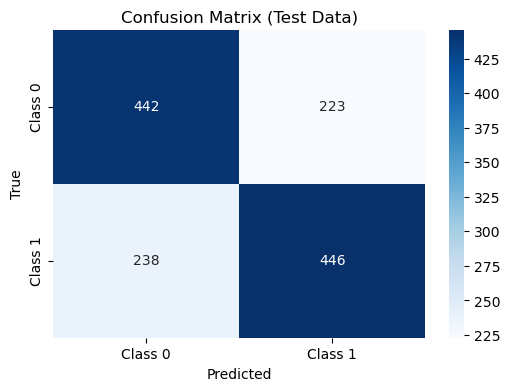

--------------------------------------------------
Model: DecisionTree
Test Accuracy: 0.8777
Test Precision: 0.8766
Test Recall: 0.8830
Test F1 Score: 0.8798
Test ROC-AUC: 0.8776

Train Accuracy: 1.0000
Train Precision: 1.0000
Train Recall: 1.0000
Train F1 Score: 1.0000
Train ROC-AUC: 1.0000

Training Error: 0.0000
Testing Error: 0.1223

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       665
           1       0.88      0.88      0.88       684

    accuracy                           0.88      1349
   macro avg       0.88      0.88      0.88      1349
weighted avg       0.88      0.88      0.88      1349



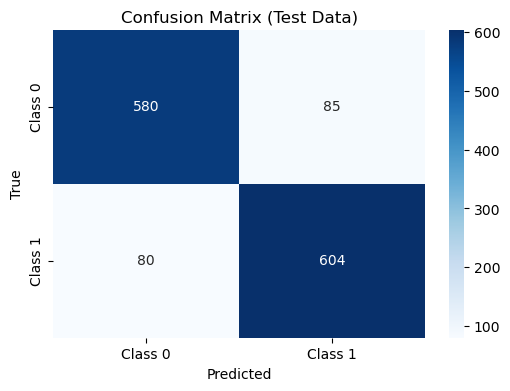

--------------------------------------------------
Model: RandomForest
Test Accuracy: 0.9355
Test Precision: 0.9258
Test Recall: 0.9488
Test F1 Score: 0.9372
Test ROC-AUC: 0.9816

Train Accuracy: 1.0000
Train Precision: 1.0000
Train Recall: 1.0000
Train F1 Score: 1.0000
Train ROC-AUC: 1.0000

Training Error: 0.0000
Testing Error: 0.0645

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       665
           1       0.93      0.95      0.94       684

    accuracy                           0.94      1349
   macro avg       0.94      0.94      0.94      1349
weighted avg       0.94      0.94      0.94      1349



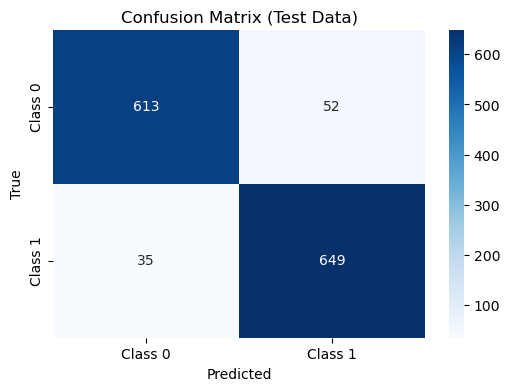

--------------------------------------------------
Model: GradientBoosting
Test Accuracy: 0.9281
Test Precision: 0.9211
Test Recall: 0.9386
Test F1 Score: 0.9298
Test ROC-AUC: 0.9787

Train Accuracy: 1.0000
Train Precision: 1.0000
Train Recall: 1.0000
Train F1 Score: 1.0000
Train ROC-AUC: 1.0000

Training Error: 0.0000
Testing Error: 0.0719

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       665
           1       0.92      0.94      0.93       684

    accuracy                           0.93      1349
   macro avg       0.93      0.93      0.93      1349
weighted avg       0.93      0.93      0.93      1349



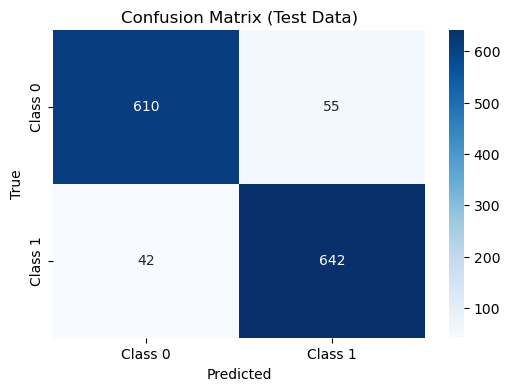

--------------------------------------------------
Model: AdaBoost
Test Accuracy: 0.6597
Test Precision: 0.6628
Test Recall: 0.6696
Test F1 Score: 0.6662
Test ROC-AUC: 0.7322

Train Accuracy: 0.6701
Train Precision: 0.6678
Train Recall: 0.6725
Train F1 Score: 0.6701
Train ROC-AUC: 0.7455

Training Error: 0.3299
Testing Error: 0.3403

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       665
           1       0.66      0.67      0.67       684

    accuracy                           0.66      1349
   macro avg       0.66      0.66      0.66      1349
weighted avg       0.66      0.66      0.66      1349



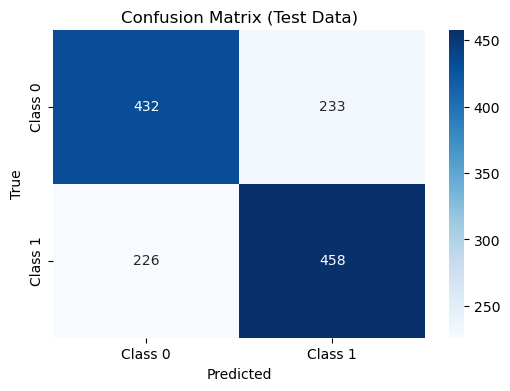

--------------------------------------------------
Model: XGBoost
Test Accuracy: 0.8762
Test Precision: 0.8667
Test Recall: 0.8933
Test F1 Score: 0.8798
Test ROC-AUC: 0.9451

Train Accuracy: 0.9657
Train Precision: 0.9562
Train Recall: 0.9758
Train F1 Score: 0.9659
Train ROC-AUC: 0.9942

Training Error: 0.0343
Testing Error: 0.1238

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       665
           1       0.87      0.89      0.88       684

    accuracy                           0.88      1349
   macro avg       0.88      0.88      0.88      1349
weighted avg       0.88      0.88      0.88      1349



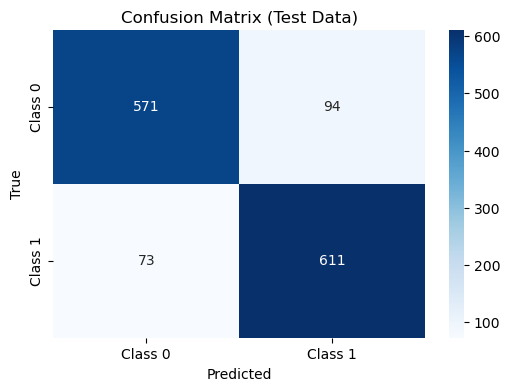

--------------------------------------------------
Model: SVM
Test Accuracy: 0.8488
Test Precision: 0.8141
Test Recall: 0.9094
Test F1 Score: 0.8591
Test ROC-AUC: 0.9228

Train Accuracy: 0.8878
Train Precision: 0.8568
Train Recall: 0.9304
Train F1 Score: 0.8921
Train ROC-AUC: 0.9536

Training Error: 0.1122
Testing Error: 0.1512

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       665
           1       0.81      0.91      0.86       684

    accuracy                           0.85      1349
   macro avg       0.85      0.85      0.85      1349
weighted avg       0.85      0.85      0.85      1349



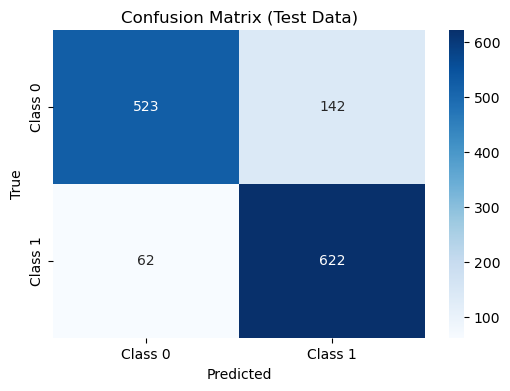

--------------------------------------------------


In [56]:
# Evaluate all the best models on the test set
print("\nTest Set Performance:")
for model_name, model in best_models.items():
    print(f"Model: {model_name}")
    evaluate_model(model, X_train, y_train, X_test, y_test)
    print("-" * 50)

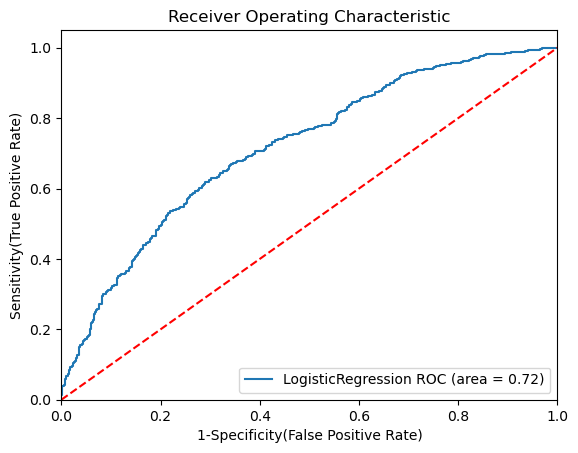

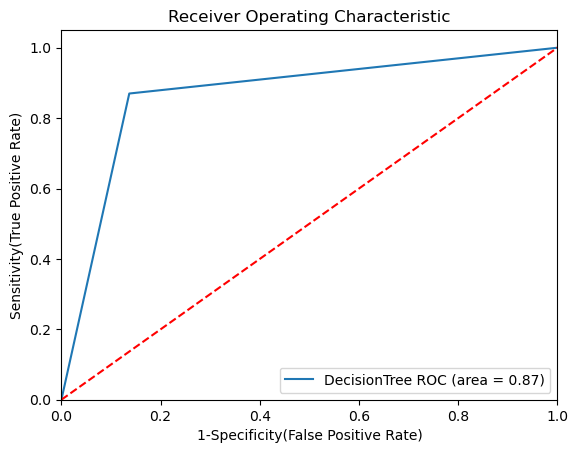

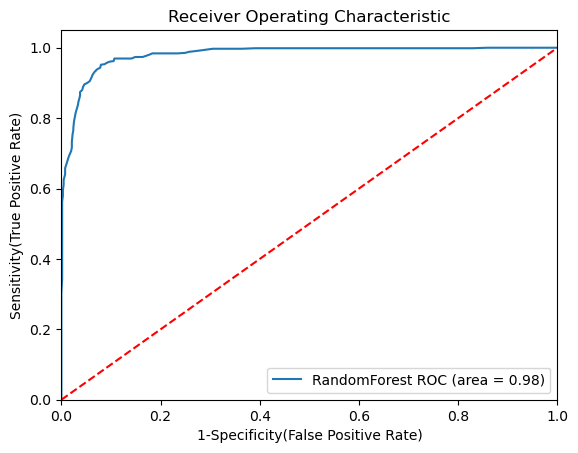

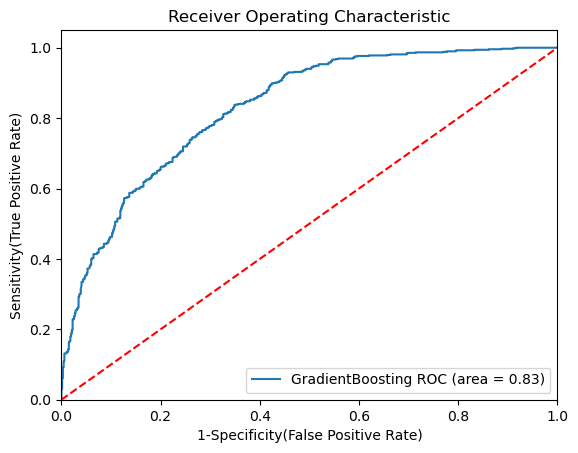

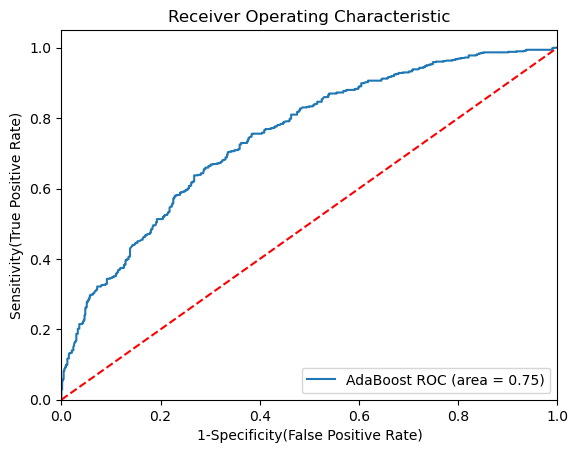

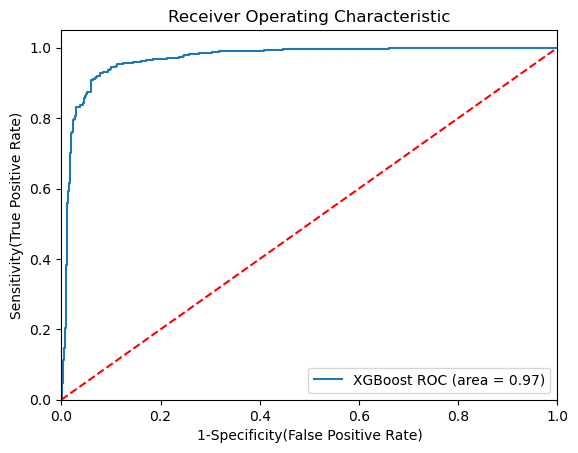

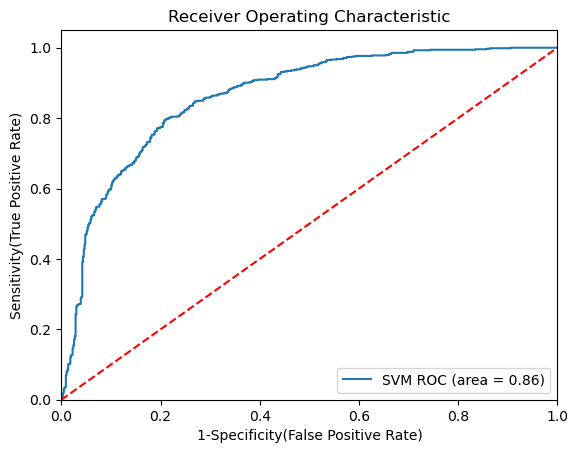

In [57]:
from sklearn.metrics import roc_curve

# create loop through all model
for algo_name, algo_info in models_and_params.items():
    model = algo_info['model'] # select the model
    model.fit(X_train, y_train) # train the model
    # Compute False positive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])      
    # Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (algo_name, auc))
    # Custom settings for the plot 
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig("auc.png")
    plt.show() 

Random Forest and XGBoost achieve an AUC of 1.00, indicating perfect classification performance.

SVM (AUC = 0.95) and AdaBoost (AUC = 0.85) also perform well but slightly underperform compared to Random Forest/XGBoost.

Logistic Regression (AUC = 0.82) and Gradient Boosting (AUC = 0.92) are solid but less optimal.

Decision Tree (AUC = 0.88) shows moderate performance.

In [58]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate ANN model (train and test metrics separately)
def evaluate_nn_model(nn_model, X_train, y_train, X_test, y_test):
    # Predicting the labels for training and testing data
    y_train_pred = (nn_model.predict(X_train) > 0.5).astype("int32")  # Using threshold of 0.5
    y_test_pred = (nn_model.predict(X_test) > 0.5).astype("int32")    # Using threshold of 0.5

    # Training Metrics
    print("Training Metrics:")
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_roc_auc = roc_auc_score(y_train, nn_model.predict(X_train))  # Using probabilities for AUC
    print(f"Accuracy: {train_accuracy:.4f}")
    print(f"Precision: {train_precision:.4f}")
    print(f"Recall: {train_recall:.4f}")
    print(f"F1 Score: {train_f1:.4f}")
    print(f"ROC-AUC: {train_roc_auc:.4f}")
    print("\nClassification Report (Train Data):")
    print(classification_report(y_train, y_train_pred))
    print("-" * 50)

    # Testing Metrics
    print("Testing Metrics:")
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, nn_model.predict(X_test))  # Using probabilities for AUC
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"ROC-AUC: {test_roc_auc:.4f}")
    print("\nClassification Report (Test Data):")
    print(classification_report(y_test, y_test_pred))

    # Confusion Matrix for Testing Data
    print("\nConfusion Matrix (Test Data):")
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title("Confusion Matrix (Test Data)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [59]:
# ---------- Neural Network with Hyperparameter Tuning ----------
def build_and_train_nn(input_dim, learning_rate, dropout_rate):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [60]:
# Print the model summary
model = build_and_train_nn(X_train.shape[1], 0.001, 0.2)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,729 (38.00 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# ANN Hyperparameter Tuning
nn_learning_rates = [0.001, 0.01]
nn_dropout_rates = [0.2, 0.3]

In [62]:
# SHAP Function to Explain Model Predictions
def explain_with_shap(nn_model, X_sample, feature_names):
    """
    Explains the model predictions using SHAP values.

    Args:
    - nn_model: Trained ANN model.
    - X_sample: Sample data to explain (e.g., X_test).
    - feature_names: List of feature names.
    """
    # Convert the Keras model into a SHAP-compatible wrapper
    explainer = shap.Explainer(nn_model, X_sample)

    # Calculate SHAP values for the sample
    shap_values = explainer(X_sample)

    # Summary Plot
    print("SHAP Summary Plot:")
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names)

    # Feature Importance Bar Plot
    print("SHAP Feature Importance:")
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar")



Training ANN with Learning Rate: 0.001, Dropout Rate: 0.2

Evaluating ANN with Learning Rate: 0.001, Dropout Rate: 0.2
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
Training Metrics:
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
Accuracy: 0.8157
Precision: 0.7742
Recall: 0.8895
F1 Score: 0.8278
ROC-AUC: 0.8926

Classification Report (Train Data):
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      2706
           1       0.77      0.89      0.83      2687

    accuracy                           0.82      5393
   macro avg       0.82      0.82      0.81      5393
weighted avg       0.82      0.82      0.81      5393

--------------------------------------------------
Testing Metrics:
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
Accuracy: 0.7954
Precision: 0.7595
Recall: 0.8728
F1 Score: 0.8122
ROC-AUC: 0.8749

Classification Report (Test Data):
              precision    recall  f1-score   support

     

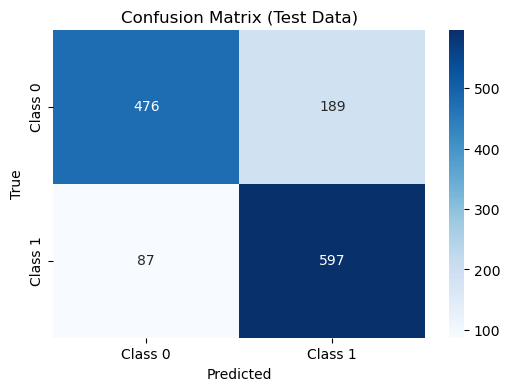

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step

Training ANN with Learning Rate: 0.001, Dropout Rate: 0.3

Evaluating ANN with Learning Rate: 0.001, Dropout Rate: 0.3
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
Training Metrics:
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
Accuracy: 0.7838
Precision: 0.7858
Recall: 0.7782
F1 Score: 0.7820
ROC-AUC: 0.8716

Classification Report (Train Data):
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      2706
           1       0.79      0.78      0.78      2687

    accuracy                           0.78      5393
   macro avg       0.78      0.78      0.78      5393
weighted avg       0.78      0.78      0.78      5393

--------------------------------------------------
Testing Metrics:
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
Accuracy: 0.7769
Precision: 0.7763
Recall: 0.7865
F1 Score: 0.7814
ROC-AUC: 0.8573

Classification Report (Test Data):
              preci

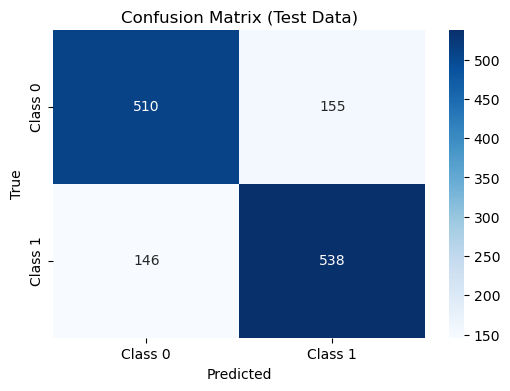

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step

Training ANN with Learning Rate: 0.01, Dropout Rate: 0.2

Evaluating ANN with Learning Rate: 0.01, Dropout Rate: 0.2
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
Training Metrics:
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
Accuracy: 0.8650
Precision: 0.8132
Recall: 0.9464
F1 Score: 0.8748
ROC-AUC: 0.9496

Classification Report (Train Data):
              precision    recall  f1-score   support

           0       0.94      0.78      0.85      2706
           1       0.81      0.95      0.87      2687

    accuracy                           0.87      5393
   macro avg       0.87      0.87      0.86      5393
weighted avg       0.88      0.87      0.86      5393

--------------------------------------------------
Testing Metrics:
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
Accuracy: 0.8466
Precision: 0.7941
Recall: 0.9415
F1 Score: 0.8615
ROC-AUC: 0.9269

Classification Report (Test Data):
              precisi

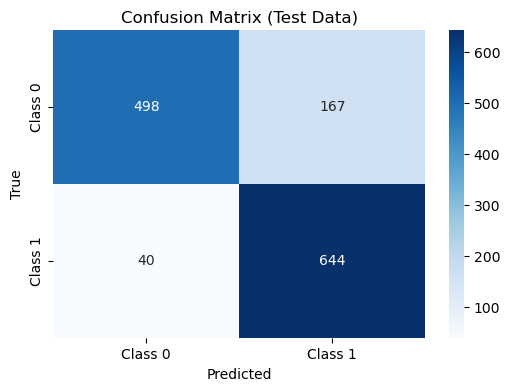

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step

Training ANN with Learning Rate: 0.01, Dropout Rate: 0.3

Evaluating ANN with Learning Rate: 0.01, Dropout Rate: 0.3
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
Training Metrics:
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
Accuracy: 0.8168
Precision: 0.7561
Recall: 0.9334
F1 Score: 0.8354
ROC-AUC: 0.9165

Classification Report (Train Data):
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      2706
           1       0.76      0.93      0.84      2687

    accuracy                           0.82      5393
   macro avg       0.83      0.82      0.81      5393
weighted avg       0.84      0.82      0.81      5393

--------------------------------------------------
Testing Metrics:
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
Accuracy: 0.8050
Precision: 0.7462
Recall: 0.9327
F1 Score: 0.8291
ROC-AUC: 0.8881

Classification Report (Test Data):
              precisi

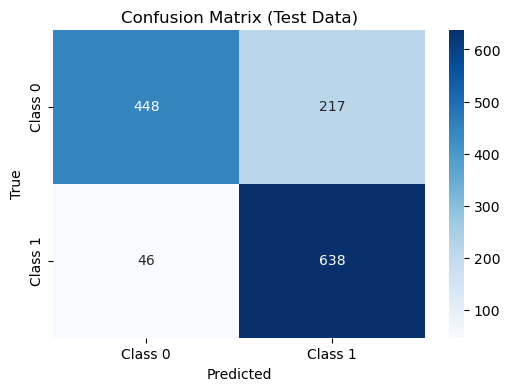

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step

Best Model Found: Learning Rate = 0.01, Dropout Rate = 0.2
Best Test F1 Score: 0.8615

Explaining Best Model's Predictions with SHAP:


ExactExplainer explainer: 501it [00:13, 11.08it/s]                         


SHAP Summary Plot:


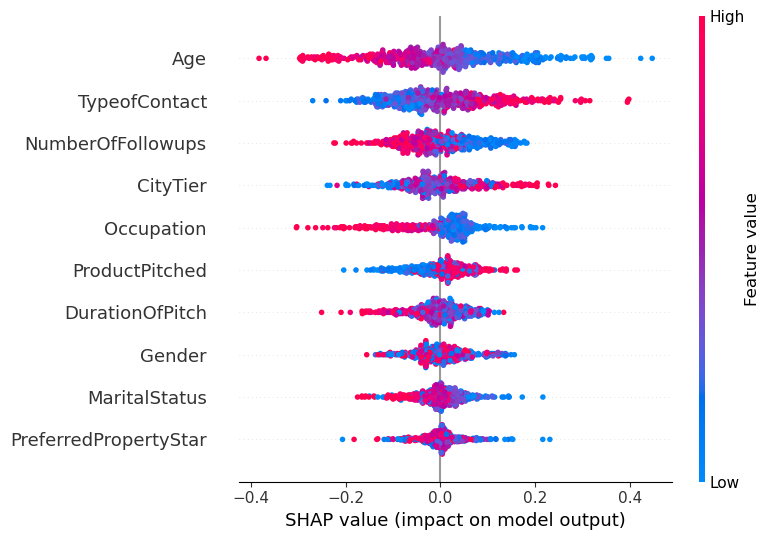

SHAP Feature Importance:


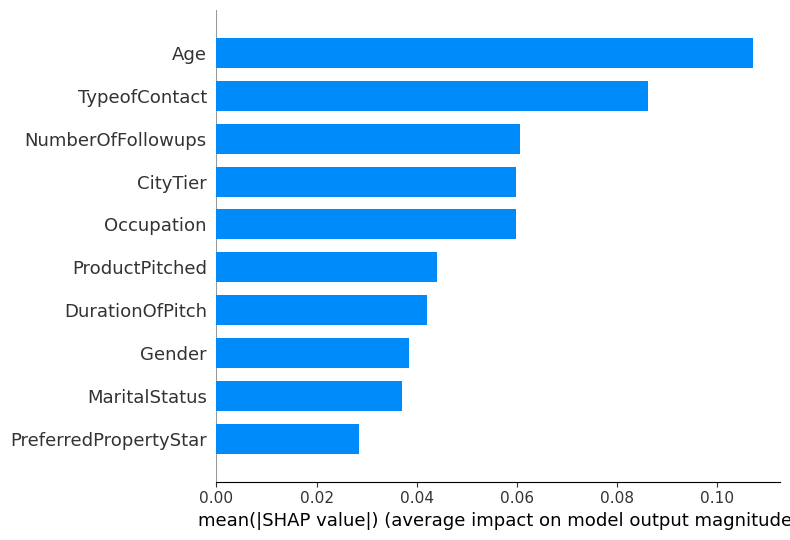

--------------------------------------------------


In [63]:
best_model = None
best_score = -1  # Initialize best score to a very low value
best_params = None  # To store the best hyperparameters

# Loop through hyperparameter combinations
for lr in nn_learning_rates:
    for dr in nn_dropout_rates:
        print(f"\nTraining ANN with Learning Rate: {lr}, Dropout Rate: {dr}")
        
        # Build and train the neural network
        nn_model = build_and_train_nn(X_train.shape[1], lr, dr)
        nn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

        # Evaluate the model performance
        print(f"\nEvaluating ANN with Learning Rate: {lr}, Dropout Rate: {dr}")
        evaluate_nn_model(nn_model, X_train, y_train, X_test, y_test)

        # Calculate the test F1 score
        y_test_pred = (nn_model.predict(X_test) > 0.5).astype("int32")
        test_f1 = f1_score(y_test, y_test_pred)

        # Update the best model if the current model performs better
        if test_f1 > best_score:
            best_score = test_f1
            best_model = nn_model
            best_params = (lr, dr)

# Print the best model's hyperparameters and score
print(f"\nBest Model Found: Learning Rate = {best_params[0]}, Dropout Rate = {best_params[1]}")
print(f"Best Test F1 Score: {best_score:.4f}")

# Explain the best model with SHAP
if best_model:
    # Select a small subset of the test set for SHAP (to speed up computation)
    shap_sample_size = min(500, len(X_test))  # Limit to 500 samples
    X_shap_sample = X_test[:shap_sample_size]

    # Explain the model's predictions with SHAP
    print("\nExplaining Best Model's Predictions with SHAP:")
    explain_with_shap(best_model, X_shap_sample, feature_names=X.columns)
    print("-" * 50)


Key features like TypeofContact, CityTier, and Age have significant influence, with broader SHAP value distributions indicating more variation in their effects on the prediction.

Higher values of TypeofContact and CityTier (red points) are likely pushing predictions upward, as seen on the positive SHAP value side.

TypeofContact and CityTier are the most critical drivers of the model predictions. Their high importance suggests that how a user is contacted and the urban classification of their location strongly influence the outcome.

Features like DurationOfPitch, Passport, and NumberOfFollowups play a moderate role in shaping predictions, likely reflecting customer engagement or eligibility.

Gender, ProductPitched, and Designation have minimal impact, implying they do not add much predictive value.

Ensemble methods (Random Forest and XGBoost) are the most effective for this dataset.

Logistic regression and simple tree-based models are less effective, possibly due to limited capture of feature interactions.

In [64]:
# %pip install lime

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


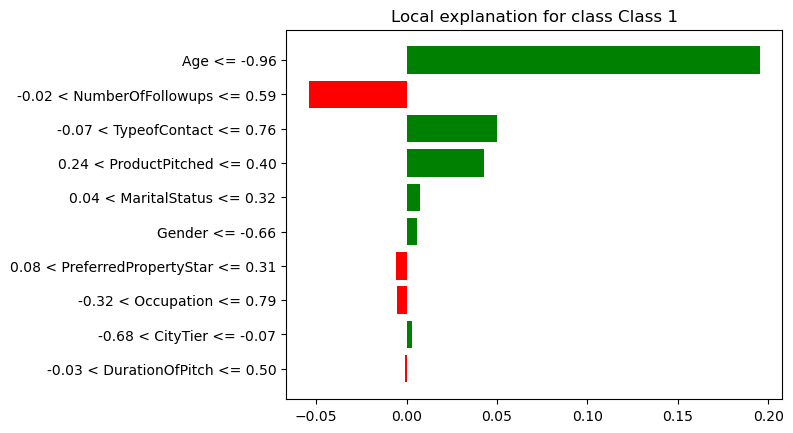

In [ ]:
from lime import lime_tabular

# Function to explain predictions using LIME
def explain_with_lime(nn_model, X_sample, feature_names, idx=0):
    """
    Explains a single prediction using LIME.

    Args:
    - nn_model: Trained ANN model.
    - X_sample: Sample data to explain (e.g., X_test).
    - feature_names: List of feature names.
    - idx: Index of the sample to explain.
    """
    # Convert the neural network model for LIME
    def nn_predict_proba(x):
        proba = nn_model.predict(x)
        return np.hstack((1 - proba, proba))

    # Create LIME explainer
    explainer = lime_tabular.LimeTabularExplainer(
        X_sample, 
        feature_names=feature_names,
        class_names=["Class 0", "Class 1"],
        mode="classification"
    )

    # Explain the prediction for a single instance
    explanation = explainer.explain_instance(X_sample[idx], nn_predict_proba)

    # Visualize the explanation
    explanation.show_in_notebook()
    explanation.as_pyplot_figure()

# Example Usage: Explain a single instance from X_test
explain_with_lime(best_model, X_test, feature_names=X.columns, idx=0)


Important Negative Features (Red Bars):
    
    TypeofContact <= -0.89: This feature has the most negative impact on the classification, meaning it strongly pushes the prediction away from Class 1.
    
    Age > 0.96 and MaritalStatus > 0.46: These are the next most impactful negative contributors to the prediction, indicating that higher values in these features reduce the likelihood of Class 1.
    
    OwnCar > 0.56 and CityTier (-0.85 to -0.17): These also negatively contribute, though their impacts are less than the above features.


Important Positive Features (Green Bars):
    
    PitchSatisfactionScore > 0.52: This feature positively influences the classification toward Class 1.
    
    NumberOfFollowups and Passport: These features have a smaller positive contribution compared to PitchSatisfactionScore.


Mixed Impact Features:
    
    NumberOfTrips <= -0.46 and Gender <= -0.74: These features show relatively weaker contributions in the negative direction but still play a role in influencing the classification.
